<a href="https://colab.research.google.com/github/baskayj/Boundary-behaviour-in-stochastic-differential-equations-used-in-Finance/blob/master/CIR_Boundary_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Boundary behaviour in stochastic differential equations used in Finance

In [0]:
import time
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import multiprocessing as mp
import pandas as pd

from collections import namedtuple
from google.colab import drive
from datetime import datetime

from scipy.stats import ks_2samp

In [2]:
#To load and save simulation data

drive.mount('/content/gdrive')
DATA_PATH = '/content/gdrive/My Drive/MSc. Szakdolgozat/Data/'

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [0]:
font = {'size'   : 18}
plt.rc('font', **font)

In [0]:
#CIR MODEL
#There are multiple finite-diffrence schemes for simulation including,
#Euler-Maryama Scheme: X[i] = X[i-1] + kappa*(theta-X[i-1])*dt + sigma*np.sqrt(X[i-1])*W[i-1]*np.sqrt(dt)
#Weighted Milstein Scheme: X[i] = (X[i-1] + kappa*(theta-alpha*X[i-1])*dt + sigma*np.sqrt(X[i-1])*W[i-1]*np.sqrt(dt) + (1/4)*np.power(sigma,2)*dt*(np.power(W[i-1],2)-1))/(1+(1-alpha)*kappa*dt)
#Non-central chi^2 method which means taking values for the expected distribution.

#gamma = 2*kappa*theta/sigma^2

#-------------------------------------------------------------------------------
def CIR_prcss(X0, dt, T, kappa, theta, sigma, seed, **kwargs):
  if kwargs.get('WMS'):
  #Weighted Milstein Scheme

    if kwargs.get('Path'):
    #Returns the entire trajectory
      N = int(T/dt)
      alpha = 0.8
      np.random.seed(seed)
      W = np.random.normal(size=N)
      X = np.zeros(N)
      X[0] = X0
      for i in range(1,N):
        x = (X[i-1] + kappa*(theta-alpha*X[i-1])*dt + sigma*np.sqrt(X[i-1])*W[i-1]*np.sqrt(dt) + (1/4)*np.power(sigma,2)*dt*(np.power(W[i-1],2)-1))/(1+(1-alpha)*kappa*dt)
        if x < 0 :
          X[i] = 0
        else:
          X[i] = x
      return X

    elif kwargs.get('Barrier'):
    #Returns wich barrier was hit first by the trajectory. (0 or 2*X0 or neither)
      N = int(T/dt)
      alpha = 0.8
      np.random.seed(seed)
      W = np.random.normal(size=N)
      X = np.zeros(N)
      X[0] = X0
      for i in range(1,N):
        x = (X[i-1] + kappa*(theta-alpha*X[i-1])*dt + sigma*np.sqrt(X[i-1])*W[i-1]*np.sqrt(dt) + (1/4)*np.power(sigma,2)*dt*(np.power(W[i-1],2)-1))/(1+(1-alpha)*kappa*dt)
        if x < 0 :
          return -1
        elif x > (2*X0):
          return 1    
        else:
          X[i] = x
      return 0

    elif kwargs.get('Sticky_Boundary'):
    #Returns the endpoint only for sticky 0-boundary
      N = int(T/dt)
      alpha = 0.8
      np.random.seed(seed)
      W = np.random.normal(size=N)
      X = np.zeros(N)
      X[0] = X0
      for i in range(1,N):
        if X[i-1] == 0:
          X[i] = 0
        else:
          x = (X[i-1] + kappa*(theta-alpha*X[i-1])*dt + sigma*np.sqrt(X[i-1])*W[i-1]*np.sqrt(dt) + (1/4)*np.power(sigma,2)*dt*(np.power(W[i-1],2)-1))/(1+(1-alpha)*kappa*dt)
          if x < 0 :
            X[i] = 0
          else:
            X[i] = x
      return X[N-1]
      
    else:
    #Returns Endpoint Only
      N = int(T/dt)
      alpha = 0.8
      np.random.seed(seed)
      W = np.random.normal(size=N)
      X = np.zeros(N)
      X[0] = X0
      for i in range(1,N):
        x = (X[i-1] + kappa*(theta-alpha*X[i-1])*dt + sigma*np.sqrt(X[i-1])*W[i-1]*np.sqrt(dt) + (1/4)*np.power(sigma,2)*dt*(np.power(W[i-1],2)-1))/(1+(1-alpha)*kappa*dt)
        if x < 0 :
          X[i] = 0
        else:
          X[i] = x
      return X[N-1]

#-------------------------------------------------------------------------------  
  elif kwargs.get('Exact'):
  #Exact Scheme (Non-central chi^2 method)
  
    if kwargs.get('Path'):
    #Returns the entire trajectory
      k = ((4*kappa*theta)/(np.power(sigma,2)))                                     # Degrees of Freedom
      eta = (4*kappa*np.exp(-kappa*dt))/(np.power(sigma,2)*(1-np.exp(-kappa*dt)))   # Helper function for the Non-centrality parameter

      N = int(T/dt)
      np.random.seed(seed)
      X = np.zeros(N)
      X[0] = X0
      for i in range(1,N):
        X[i] = np.random.noncentral_chisquare(k,X[i-1]*eta) * ((np.power(sigma,2)*(1-np.exp(-kappa*dt)))/(4*kappa))
      return X

    elif kwargs.get('Barrier'):
    #Returns wich barrier was hit first by the trajectory. (0 or 2*X0 or neither)
      k = ((4*kappa*theta)/(np.power(sigma,2)))                                     # Degrees of Freedom
      eta = (4*kappa*np.exp(-kappa*dt))/(np.power(sigma,2)*(1-np.exp(-kappa*dt)))   # Helper function for the Non-centrality parameter

      N = int(T/dt)
      np.random.seed(seed)
      X = np.zeros(N)
      X[0] = X0
      for i in range(1,N):
        x = np.random.noncentral_chisquare(k,X[i-1]*eta) * ((np.power(sigma,2)*(1-np.exp(-kappa*dt)))/(4*kappa))
        if x < dt :
          return -1
        elif x > (2*X0):
          return 1    
        else:
          X[i] = x
      return 0

    else:
    #Returns Endpoint Only
      k = ((4*kappa*theta)/(np.power(sigma,2)))                                     # Degrees of Freedom
      eta = (4*kappa*np.exp(-kappa*dt))/(np.power(sigma,2)*(1-np.exp(-kappa*dt)))   # Helper function for the Non-centrality parameter

      N = int(T/dt)
      np.random.seed(seed)
      X = np.zeros(N)
      X[0] = X0
      for i in range(1,N):
        X[i] = np.random.noncentral_chisquare(k,X[i-1]*eta) * ((np.power(sigma,2)*(1-np.exp(-kappa*dt)))/(4*kappa))
      return X[N-1]
#-------------------------------------------------------------------------------
  elif kwargs.get('SOUP'):
  #squared Ornstein-Uhlenbeck process
  
    if kwargs.get('Path'):
      N = int(T/dt)
      np.random.seed(seed)
      W = np.random.normal(size=N)
      X1 = np.zeros(N)
      X2 = np.zeros(N)
      X1[0] = np.sqrt(X0)
      X2[0] = -np.sqrt(X0)
      for i in range(1,N):
        X1[i] = X1[i-1] - (kappa/2)*X1[i-1]*dt + (sigma/2)*W[i-1]*np.sqrt(dt)
        X2[i] = X2[i-1] - (kappa/2)*X2[i-1]*dt - (sigma/2)*W[i-1]*np.sqrt(dt)
      if kwargs.get('Reflective_Boundary'):
        return np.power(((X1 - X2)/2),2)
      else:
        return np.power(((X1 + X2)/2),2)

    else:
      N = int(T/dt)
      np.random.seed(seed)
      W = np.random.normal(size=N)
      X1 = np.zeros(N)
      X2 = np.zeros(N)
      X1[0] = np.sqrt(X0)
      X2[0] = -np.sqrt(X0)
      if kwargs.get('Reflective_Boundary'):
        for i in range(1,N):
          X1[i] = X1[i-1] - (kappa/2)*X1[i-1]*dt + (sigma/2)*W[i-1]*np.sqrt(dt)
          X2[i] = X2[i-1] - (kappa/2)*X2[i-1]*dt - (sigma/2)*W[i-1]*np.sqrt(dt)
        return np.power(((X1 - X2)/2),2)[N-1]
      else:
        for i in range(1,N):
          X1[i] = X1[i-1] - (kappa/2)*X1[i-1]*dt + (sigma/2)*W[i-1]*np.sqrt(dt)
          X2[i] = X2[i-1] + (kappa/2)*X2[i-1]*dt - (sigma/2)*W[i-1]*np.sqrt(dt)
        return np.power(((X1 + X2)/2),2)[N-1]
#-------------------------------------------------------------------------------
  else:
  #Euler-Maryama Scheme
  
    if kwargs.get('Path'):
    #Returns the entire trajectory
      N = int(T/dt)
      np.random.seed(seed)
      W = np.random.normal(size=N)
      X = np.zeros(N)
      X[0] = X0
      for i in range(1,N):
        x = X[i-1] + kappa*(theta-X[i-1])*dt + sigma*np.sqrt(X[i-1])*W[i-1]*np.sqrt(dt)
        if x < 0 :
          X[i] = 0
        else:
          X[i] = x
      return X

    elif kwargs.get('Barrier'):
    #Returns wich barrier was hit first by the trajectory. (0 or 2*X0 or neither)
      N = int(T/dt)
      np.random.seed(seed)
      W = np.random.normal(size=N)
      X = np.zeros(N)
      X[0] = X0
      for i in range(1,N):
        x = X[i-1] + kappa*(theta-X[i-1])*dt + sigma*np.sqrt(X[i-1])*W[i-1]*np.sqrt(dt)
        if x < 0 :
          return -1
        elif x > (2*X0):
          return 1    
        else:
          X[i] = x
      return 0
    elif kwargs.get('Sticky_Boundary'):
    #Returns the endpoint only for sticky 0-boundary
      N = int(T/dt)
      np.random.seed(seed)
      W = np.random.normal(size=N)
      X = np.zeros(N)
      X[0] = X0
      for i in range(1,N):
        if X[i-1] == 0:
          X[i] = 0
        else:
          x = X[i-1] + kappa*(theta-X[i-1])*dt + sigma*np.sqrt(X[i-1])*W[i-1]*np.sqrt(dt)
          if x < 0 :
            X[i] = 0
          else:
            X[i] = x
      return X[N-1]

    else:
    #Returns Endpoint Only
      N = int(T/dt)
      np.random.seed(seed)
      W = np.random.normal(size=N)
      X = np.zeros(N)
      X[0] = X0
      for i in range(1,N):
        x = X[i-1] + kappa*(theta-X[i-1])*dt + sigma*np.sqrt(X[i-1])*W[i-1]*np.sqrt(dt)
        if x < 0 :
          X[i] = 0
        else:
          X[i] = x
      return X[N-1]

In [0]:
# CLASS for MP

class CIR():
  def __init__(self,X0,dt,T,kappa,theta,sigma):
    self.X0 = X0
    self.dt = dt
    self.T = T
    self.kappa = kappa
    self.theta = theta
    self.sigma = sigma

  def Prcss_WMS_Path(self,seed):
    return CIR_prcss(self.X0, self.dt, self.T, self.kappa, self.theta, self.sigma, seed, WMS = True, Path = True)
  def Prcss_WMS_Barrier(self,seed):
    return CIR_prcss(self.X0, self.dt, self.T, self.kappa, self.theta, self.sigma, seed, WMS = True, Barrier = True)
  def Prcss_WMS_Sticky(self,seed):
    return CIR_prcss(self.X0, self.dt, self.T, self.kappa, self.theta, self.sigma, seed, WMS = True, Sticky_Boundary = True)
  def Prcss_WMS(self,seed):
    return CIR_prcss(self.X0, self.dt, self.T, self.kappa, self.theta, self.sigma, seed, WMS = True)

  def Prcss_Exact_Path(self,seed):
    return CIR_prcss(self.X0, self.dt, self.T, self.kappa, self.theta, self.sigma, seed, Exact = True, Path = True)
  def Prcss_Exact_Barrier(self,seed):
    return CIR_prcss(self.X0, self.dt, self.T, self.kappa, self.theta, self.sigma, seed, Exact = True, Barrier = True)
  def Prcss_Exact(self,seed):
    return CIR_prcss(self.X0, self.dt, self.T, self.kappa, self.theta, self.sigma, seed, Exact = True)

  def Prcss_SOUP_Path_RB(self,seed):
    return CIR_prcss(self.X0, self.dt, self.T, self.kappa, self.theta, self.sigma, seed, SOUP = True, Path = True, Reflective_Boundary = "True")
  def Prcss_SOUP_Path(self,seed):
    return CIR_prcss(self.X0, self.dt, self.T, self.kappa, self.theta, self.sigma, seed, SOUP = True, Path = True)
  def Prcss_SOUP_RB(self,seed):
    return CIR_prcss(self.X0, self.dt, self.T, self.kappa, self.theta, self.sigma, seed, SOUP = True, Reflective_Boundary = "True")
  def Prcss_SOUP(self,seed):
    return CIR_prcss(self.X0, self.dt, self.T, self.kappa, self.theta, self.sigma, seed, SOUP = True)

  def Prcss_Path(self,seed):
    return CIR_prcss(self.X0, self.dt, self.T, self.kappa, self.theta, self.sigma, seed, Path = True)
  def Prcss_Barrier(self,seed):
    return CIR_prcss(self.X0, self.dt, self.T, self.kappa, self.theta, self.sigma, seed, Barrier = True)
  def Prcss_Sticky(self,seed):
    return CIR_prcss(self.X0, self.dt, self.T, self.kappa, self.theta, self.sigma, seed, Sticky_Boundary = True)
  def Prcss(self,seed):
    return CIR_prcss(self.X0, self.dt, self.T, self.kappa, self.theta, self.sigma, seed)

In [0]:
#MULTIPROCESS FUNCTION

def CIR_Prcss_mp(X0,dt,T,kappa,theta,sigma,**kwargs):
  cir = CIR(X0,dt,T,kappa,theta,sigma)
  pool = mp.Pool(processes=mp.cpu_count())
  if kwargs.get('WMS'):
    if kwargs.get('Path'):
      R = pool.map(cir.Prcss_WMS_Path,range(mc_rep))
      pool.close()
      return R
    elif kwargs.get('Barrier'):
      R = pool.map(cir.Prcss_WMS_Barrier,range(mc_rep))
      pool.close()
      return R
    elif kwargs.get('Sticky_Boundary'):
      R = pool.map(cir.Prcss_WMS_Sticky,range(mc_rep))
      pool.close()
      return R
    else:
      R = pool.map(cir.Prcss_WMS,range(mc_rep))
      pool.close()
      return R
  elif kwargs.get('Exact'):
    if kwargs.get('Path'):
      R = pool.map(cir.Prcss_Exact_Path,range(mc_rep))
      pool.close()
      return R
    elif kwargs.get('Barrier'):
      R = pool.map(cir.Prcss_Exact_Barrier,range(mc_rep))
      pool.close()
      return R
    else:
      R = pool.map(cir.Prcss_Exact,range(mc_rep))
      pool.close()
      return R
  elif kwargs.get('SOUP'):
    if kwargs.get('Path'):
      if kwargs.get('Reflective_Boundary'):
        R = pool.map(cir.Prcss_SOUP_Path_RB,range(mc_rep))
        pool.close()
        return R
      else:
        R = pool.map(cir.Prcss_SOUP_Path,range(mc_rep))
        pool.close()
        return R
    else:
      if kwargs.get('Reflective_Boundary'):
        R = pool.map(cir.Prcss_SOUP_RB,range(mc_rep))
        pool.close()
        return R
      else:
        R = pool.map(cir.Prcss_SOUP,range(mc_rep))
        pool.close()
        return R
  else:
    if kwargs.get('Path'):
      R = pool.map(cir.Prcss_Path,range(mc_rep))
      pool.close()
      return R
    elif kwargs.get('Barrier'):
      R = pool.map(cir.Prcss_Barrier,range(mc_rep))
      pool.close()
      return R
    elif kwargs.get('Sticky_Boundary'):
      R = pool.map(cir.Prcss_Sticky,range(mc_rep))
      pool.close()
      return R
    else:
      R = pool.map(cir.Prcss,range(mc_rep))
      pool.close()
      return R

In [0]:
# MISC. FUNCTIONS

def print_log(string):
  logs = open(f"{DATA_PATH}logs.txt","a")
  logs.write(string)
  logs.close()

def sort(R):
  c0 = 0
  cm = 0
  cT = 0

  for rr in R:
    if rr == -1:
      c0 += 1
    elif rr == 1:
      cm += 1
    else:
      cT += 1
  
  res = [c0/mc_rep,cm/mc_rep,cT/mc_rep]
  return res

def Richardson(c0,h,n):
  R = []
  for i in range(len(c0)-1):
    t = (h[i+1]-h[i])/h[i]
    r = (np.power(t,n)*c0[i+1]-c0[i])/(np.power(t,n)-1)
    R.append(r)
  return min(R)

---
---

## 1.) Runtime Comparison

In [0]:
#Number of generated trajectories
mc_rep = 1000

### As a function of $\gamma$

In [9]:
model = 'CIR_'
name = 'Runtime_Euler'

print(f"\n\nStaring Experiment {model}{name}.\n")
t_euler = []

#Parameters:
Parameters = namedtuple('Parameters','X0 dt T kappa theta sigma')
P = Parameters(X0 = 0.5, dt = 0.0001, T = 1,kappa = 1, theta = 1, sigma = 0.6)

#Variables:
var_name = 'gamma'
var = np.linspace(0.1,2,10)

sigma = list(map(lambda p: np.sqrt((2*P.kappa*P.theta)/p),var))

#Transforming the parameters into a more digestable form. This way the computation heavy part of the code needs less for cycles.
T = []
for i in range(len(var)):
  T.append([P.X0,P.dt,P.T,P.kappa,P.theta,sigma[i]])

start_time = time.time()
#GENERATING ALL TRAJECTORIES
X = np.zeros((len(T),mc_rep))
for i in range(len(T)):
  print(f"Making trajectories for X0 = {T[i][0]},dt = {T[i][1]},T = {T[i][2]},kappa = {T[i][3]},theta = {T[i][4]},sigma = {T[i][5]}.\n")

  s_time = time.time()
  n = 0
  for x in CIR_Prcss_mp(T[i][0],T[i][1],T[i][2],T[i][3],T[i][4],T[i][5]):
    X[i,n] = x
    n += 1
  e_time = time.time()

  t_euler.append(e_time-s_time)
  print(f"  Finished generating trajectories in {int((e_time-s_time)/60)} minutes and {e_time-s_time-int((e_time-s_time)/60)*60} seconds.[{i+1}/{len(T)}]\n")

#Memory Management
del T
del X

end_time = time.time()

print(f"The experiment finished in {int((end_time-start_time)/60)} minutes and {end_time-start_time-int((end_time-start_time)/60)*60} seconds.\n")



Staring Experiment CIR_Runtime_Euler.

Making trajectories for X0 = 0.5,dt = 0.0001,T = 1,kappa = 1,theta = 1,sigma = 4.47213595499958.

  Finished generating trajectories in 0 minutes and 25.594053506851196 seconds.[1/10]

Making trajectories for X0 = 0.5,dt = 0.0001,T = 1,kappa = 1,theta = 1,sigma = 2.53546276418555.

  Finished generating trajectories in 0 minutes and 25.525999546051025 seconds.[2/10]

Making trajectories for X0 = 0.5,dt = 0.0001,T = 1,kappa = 1,theta = 1,sigma = 1.9569842191603266.

  Finished generating trajectories in 0 minutes and 25.47687005996704 seconds.[3/10]

Making trajectories for X0 = 0.5,dt = 0.0001,T = 1,kappa = 1,theta = 1,sigma = 1.651445647689541.

  Finished generating trajectories in 0 minutes and 25.6700382232666 seconds.[4/10]

Making trajectories for X0 = 0.5,dt = 0.0001,T = 1,kappa = 1,theta = 1,sigma = 1.4552137502179978.

  Finished generating trajectories in 0 minutes and 25.705179452896118 seconds.[5/10]

Making trajectories for X0 = 0.5

In [10]:
model = 'CIR_'
name = 'Runtime_WMS'

print(f"\n\nStaring Experiment {model}{name}.\n")
t_WMS = []

#Parameters:
Parameters = namedtuple('Parameters','X0 dt T kappa theta sigma')
P = Parameters(X0 = 0.5, dt = 0.0001, T = 1,kappa = 1, theta = 1, sigma = 0.6)

#Variables:
var_name = 'gamma'
var = np.linspace(0.1,2,10)

sigma = list(map(lambda p: np.sqrt((2*P.kappa*P.theta)/p),var))

#Transforming the parameters into a more digestable form. This way the computation heavy part of the code needs less for cycles.
T = []
for i in range(len(var)):
  T.append([P.X0,P.dt,P.T,P.kappa,P.theta,sigma[i]])

start_time = time.time()
#GENERATING ALL TRAJECTORIES
X = np.zeros((len(T),mc_rep))
for i in range(len(T)):
  print(f"Making trajectories for X0 = {T[i][0]},dt = {T[i][1]},T = {T[i][2]},kappa = {T[i][3]},theta = {T[i][4]},sigma = {T[i][5]}.\n")

  s_time = time.time()
  n = 0
  for x in CIR_Prcss_mp(T[i][0],T[i][1],T[i][2],T[i][3],T[i][4],T[i][5], WMS = "True"):
    X[i,n] = x
    n += 1
  e_time = time.time()

  t_WMS.append(e_time-s_time)
  print(f"  Finished generating trajectories in {int((e_time-s_time)/60)} minutes and {e_time-s_time-int((e_time-s_time)/60)*60} seconds.[{i+1}/{len(T)}]\n")

#Memory Management
del T
del X

end_time = time.time()

print(f"The experiment finished in {int((end_time-start_time)/60)} minutes and {end_time-start_time-int((end_time-start_time)/60)*60} seconds.\n")



Staring Experiment CIR_Runtime_WMS.

Making trajectories for X0 = 0.5,dt = 0.0001,T = 1,kappa = 1,theta = 1,sigma = 4.47213595499958.

  Finished generating trajectories in 1 minutes and 1.9829766750335693 seconds.[1/10]

Making trajectories for X0 = 0.5,dt = 0.0001,T = 1,kappa = 1,theta = 1,sigma = 2.53546276418555.

  Finished generating trajectories in 1 minutes and 0.7842245101928711 seconds.[2/10]

Making trajectories for X0 = 0.5,dt = 0.0001,T = 1,kappa = 1,theta = 1,sigma = 1.9569842191603266.

  Finished generating trajectories in 1 minutes and 1.6353123188018799 seconds.[3/10]

Making trajectories for X0 = 0.5,dt = 0.0001,T = 1,kappa = 1,theta = 1,sigma = 1.651445647689541.

  Finished generating trajectories in 1 minutes and 2.2122812271118164 seconds.[4/10]

Making trajectories for X0 = 0.5,dt = 0.0001,T = 1,kappa = 1,theta = 1,sigma = 1.4552137502179978.

  Finished generating trajectories in 1 minutes and 1.8089170455932617 seconds.[5/10]

Making trajectories for X0 = 0.

In [11]:
model = 'CIR_'
name = 'Runtime_Exact'

print(f"\n\nStaring Experiment {model}{name}.\n")
t_Exact = []

#Parameters:
Parameters = namedtuple('Parameters','X0 dt T kappa theta sigma')
P = Parameters(X0 = 0.5, dt = 0.0001, T = 1,kappa = 1, theta = 1, sigma = 0.6)

#Variables:
var_name = 'gamma'
var = np.linspace(0.1,2,10)

sigma = list(map(lambda p: np.sqrt((2*P.kappa*P.theta)/p),var))

#Transforming the parameters into a more digestable form. This way the computation heavy part of the code needs less for cycles.
T = []
for i in range(len(var)):
  T.append([P.X0,P.dt,P.T,P.kappa,P.theta,sigma[i]])

start_time = time.time()
#GENERATING ALL TRAJECTORIES
X = np.zeros((len(T),mc_rep))
for i in range(len(T)):
  print(f"Making trajectories for X0 = {T[i][0]},dt = {T[i][1]},T = {T[i][2]},kappa = {T[i][3]},theta = {T[i][4]},sigma = {T[i][5]}.\n")

  s_time = time.time()
  n = 0
  for x in CIR_Prcss_mp(T[i][0],T[i][1],T[i][2],T[i][3],T[i][4],T[i][5], Exact = "True"):
    X[i,n] = x
    n += 1
  e_time = time.time()

  t_Exact.append(e_time-s_time)
  print(f"  Finished generating trajectories in {int((e_time-s_time)/60)} minutes and {e_time-s_time-int((e_time-s_time)/60)*60} seconds.[{i+1}/{len(T)}]\n")

#Memory Management
del T
del X

end_time = time.time()

print(f"The experiment finished in {int((end_time-start_time)/60)} minutes and {end_time-start_time-int((end_time-start_time)/60)*60} seconds.\n")



Staring Experiment CIR_Runtime_Exact.

Making trajectories for X0 = 0.5,dt = 0.0001,T = 1,kappa = 1,theta = 1,sigma = 4.47213595499958.

  Finished generating trajectories in 0 minutes and 48.80100917816162 seconds.[1/10]

Making trajectories for X0 = 0.5,dt = 0.0001,T = 1,kappa = 1,theta = 1,sigma = 2.53546276418555.

  Finished generating trajectories in 0 minutes and 48.626965284347534 seconds.[2/10]

Making trajectories for X0 = 0.5,dt = 0.0001,T = 1,kappa = 1,theta = 1,sigma = 1.9569842191603266.

  Finished generating trajectories in 0 minutes and 48.64023518562317 seconds.[3/10]

Making trajectories for X0 = 0.5,dt = 0.0001,T = 1,kappa = 1,theta = 1,sigma = 1.651445647689541.

  Finished generating trajectories in 0 minutes and 48.489516735076904 seconds.[4/10]

Making trajectories for X0 = 0.5,dt = 0.0001,T = 1,kappa = 1,theta = 1,sigma = 1.4552137502179978.

  Finished generating trajectories in 0 minutes and 48.447940826416016 seconds.[5/10]

Making trajectories for X0 = 0.

In [0]:
#Calculating the relative increase in runtime
for i in range(len(t_WMS)):
  t_WMS[i] = ((t_WMS[i]/t_euler[i])-1)*100

for i in range(len(t_Exact)):
  t_Exact[i] = ((t_Exact[i]/t_euler[i])-1)*100

#### Results

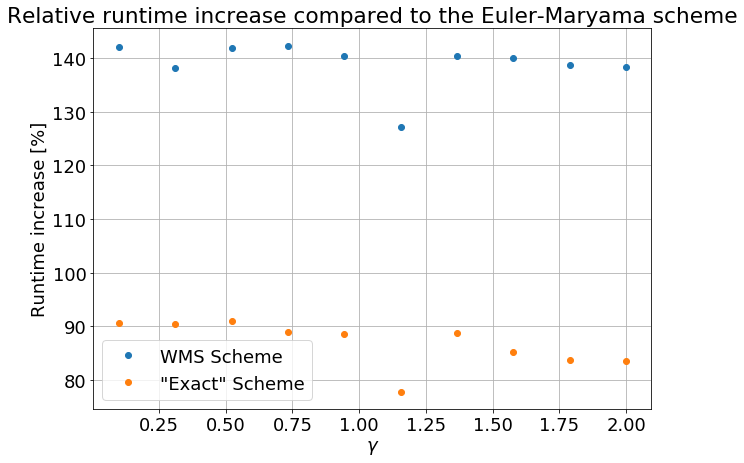

In [13]:
gammas = np.linspace(0.1,2,10)

plt.figure(figsize=(10,7))
plt.plot(gammas,t_WMS,"o", label = "WMS Scheme")
plt.plot(gammas,t_Exact,"o", label = "\"Exact\" Scheme")

plt.title("Relative runtime increase compared to the Euler-Maryama scheme")
plt.legend()
plt.xlabel("$\gamma$")
plt.ylabel("Runtime increase [%]")
plt.grid()

---

### As a function of $dt$

In [14]:
model = 'CIR_'
name = 'Runtime_Euler'

print(f"\n\nStaring Experiment {model}{name}.\n")
t_euler = []

#Parameters:
Parameters = namedtuple('Parameters','X0 dt T kappa theta sigma')
P = Parameters(X0 = 0.5, dt = 0.0001, T = 1,kappa = 1, theta = 1, sigma = 1)

#Variables:
var_name = 'dt'
var = np.logspace(np.log10(0.1),np.log10(0.0001),10)


#Transforming the parameters into a more digestable form. This way the computation heavy part of the code needs less for cycles.
T = []
for i in range(len(var)):
  T.append([P.X0,var[i],P.T,P.kappa,P.theta,P.sigma])

start_time = time.time()
#GENERATING ALL TRAJECTORIES
X = np.zeros((len(T),mc_rep))
for i in range(len(T)):
  print(f"Making trajectories for X0 = {T[i][0]},dt = {T[i][1]},T = {T[i][2]},kappa = {T[i][3]},theta = {T[i][4]},sigma = {T[i][5]}.\n")

  s_time = time.time()
  n = 0
  for x in CIR_Prcss_mp(T[i][0],T[i][1],T[i][2],T[i][3],T[i][4],T[i][5]):
    X[i,n] = x
    n += 1
  e_time = time.time()

  t_euler.append(e_time-s_time)
  print(f"  Finished generating trajectories in {int((e_time-s_time)/60)} minutes and {e_time-s_time-int((e_time-s_time)/60)*60} seconds.[{i+1}/{len(T)}]\n")

#Memory Management
del T
del X

end_time = time.time()

print(f"The experiment finished in {int((end_time-start_time)/60)} minutes and {end_time-start_time-int((end_time-start_time)/60)*60} seconds.\n")



Staring Experiment CIR_Runtime_Euler.

Making trajectories for X0 = 0.5,dt = 0.1,T = 1,kappa = 1,theta = 1,sigma = 1.

  Finished generating trajectories in 0 minutes and 0.0655515193939209 seconds.[1/10]

Making trajectories for X0 = 0.5,dt = 0.046415888336127795,T = 1,kappa = 1,theta = 1,sigma = 1.

  Finished generating trajectories in 0 minutes and 0.10246133804321289 seconds.[2/10]

Making trajectories for X0 = 0.5,dt = 0.021544346900318846,T = 1,kappa = 1,theta = 1,sigma = 1.

  Finished generating trajectories in 0 minutes and 0.1754322052001953 seconds.[3/10]

Making trajectories for X0 = 0.5,dt = 0.01,T = 1,kappa = 1,theta = 1,sigma = 1.

  Finished generating trajectories in 0 minutes and 0.3331642150878906 seconds.[4/10]

Making trajectories for X0 = 0.5,dt = 0.004641588833612782,T = 1,kappa = 1,theta = 1,sigma = 1.

  Finished generating trajectories in 0 minutes and 0.6687474250793457 seconds.[5/10]

Making trajectories for X0 = 0.5,dt = 0.0021544346900318843,T = 1,kappa

In [15]:
model = 'CIR_'
name = 'Runtime_WMS'

print(f"\n\nStaring Experiment {model}{name}.\n")
t_WMS = []

#Parameters:
Parameters = namedtuple('Parameters','X0 dt T kappa theta sigma')
P = Parameters(X0 = 0.5, dt = 0.0001, T = 1,kappa = 1, theta = 1, sigma = 1)

#Variables:
var_name = 'dt'
var = np.logspace(np.log10(0.1),np.log10(0.0001),10)


#Transforming the parameters into a more digestable form. This way the computation heavy part of the code needs less for cycles.
T = []
for i in range(len(var)):
  T.append([P.X0,var[i],P.T,P.kappa,P.theta,P.sigma])

start_time = time.time()
#GENERATING ALL TRAJECTORIES
X = np.zeros((len(T),mc_rep))
for i in range(len(T)):
  print(f"Making trajectories for X0 = {T[i][0]},dt = {T[i][1]},T = {T[i][2]},kappa = {T[i][3]},theta = {T[i][4]},sigma = {T[i][5]}.\n")

  s_time = time.time()
  n = 0
  for x in CIR_Prcss_mp(T[i][0],T[i][1],T[i][2],T[i][3],T[i][4],T[i][5], WMS = "True"):
    X[i,n] = x
    n += 1
  e_time = time.time()

  t_WMS.append(e_time-s_time)
  print(f"  Finished generating trajectories in {int((e_time-s_time)/60)} minutes and {e_time-s_time-int((e_time-s_time)/60)*60} seconds.[{i+1}/{len(T)}]\n")

#Memory Management
del T
del X

end_time = time.time()

print(f"The experiment finished in {int((end_time-start_time)/60)} minutes and {end_time-start_time-int((end_time-start_time)/60)*60} seconds.\n")



Staring Experiment CIR_Runtime_WMS.

Making trajectories for X0 = 0.5,dt = 0.1,T = 1,kappa = 1,theta = 1,sigma = 1.

  Finished generating trajectories in 0 minutes and 0.10375142097473145 seconds.[1/10]

Making trajectories for X0 = 0.5,dt = 0.046415888336127795,T = 1,kappa = 1,theta = 1,sigma = 1.

  Finished generating trajectories in 0 minutes and 0.18859553337097168 seconds.[2/10]

Making trajectories for X0 = 0.5,dt = 0.021544346900318846,T = 1,kappa = 1,theta = 1,sigma = 1.

  Finished generating trajectories in 0 minutes and 0.36841797828674316 seconds.[3/10]

Making trajectories for X0 = 0.5,dt = 0.01,T = 1,kappa = 1,theta = 1,sigma = 1.

  Finished generating trajectories in 0 minutes and 0.7799038887023926 seconds.[4/10]

Making trajectories for X0 = 0.5,dt = 0.004641588833612782,T = 1,kappa = 1,theta = 1,sigma = 1.

  Finished generating trajectories in 0 minutes and 1.625992774963379 seconds.[5/10]

Making trajectories for X0 = 0.5,dt = 0.0021544346900318843,T = 1,kappa 

In [16]:
model = 'CIR_'
name = 'Runtime_Exact'

print(f"\n\nStaring Experiment {model}{name}.\n")
t_Exact = []

#Parameters:
Parameters = namedtuple('Parameters','X0 dt T kappa theta sigma')
P = Parameters(X0 = 0.5, dt = 0.0001, T = 1,kappa = 1, theta = 1, sigma = 1)

#Variables:
var_name = 'dt'
var = np.logspace(np.log10(0.1),np.log10(0.0001),10)


#Transforming the parameters into a more digestable form. This way the computation heavy part of the code needs less for cycles.
T = []
for i in range(len(var)):
  T.append([P.X0,var[i],P.T,P.kappa,P.theta,P.sigma])

start_time = time.time()
#GENERATING ALL TRAJECTORIES
X = np.zeros((len(T),mc_rep))
for i in range(len(T)):
  print(f"Making trajectories for X0 = {T[i][0]},dt = {T[i][1]},T = {T[i][2]},kappa = {T[i][3]},theta = {T[i][4]},sigma = {T[i][5]}.\n")

  s_time = time.time()
  n = 0
  for x in CIR_Prcss_mp(T[i][0],T[i][1],T[i][2],T[i][3],T[i][4],T[i][5], Exact = "True"):
    X[i,n] = x
    n += 1
  e_time = time.time()

  t_Exact.append(e_time-s_time)
  print(f"  Finished generating trajectories in {int((e_time-s_time)/60)} minutes and {e_time-s_time-int((e_time-s_time)/60)*60} seconds.[{i+1}/{len(T)}]\n")

#Memory Management
del T
del X

end_time = time.time()

print(f"The experiment finished in {int((end_time-start_time)/60)} minutes and {end_time-start_time-int((end_time-start_time)/60)*60} seconds.\n")



Staring Experiment CIR_Runtime_Exact.

Making trajectories for X0 = 0.5,dt = 0.1,T = 1,kappa = 1,theta = 1,sigma = 1.

  Finished generating trajectories in 0 minutes and 0.09652590751647949 seconds.[1/10]

Making trajectories for X0 = 0.5,dt = 0.046415888336127795,T = 1,kappa = 1,theta = 1,sigma = 1.

  Finished generating trajectories in 0 minutes and 0.16980719566345215 seconds.[2/10]

Making trajectories for X0 = 0.5,dt = 0.021544346900318846,T = 1,kappa = 1,theta = 1,sigma = 1.

  Finished generating trajectories in 0 minutes and 0.32262444496154785 seconds.[3/10]

Making trajectories for X0 = 0.5,dt = 0.01,T = 1,kappa = 1,theta = 1,sigma = 1.

  Finished generating trajectories in 0 minutes and 0.6470654010772705 seconds.[4/10]

Making trajectories for X0 = 0.5,dt = 0.004641588833612782,T = 1,kappa = 1,theta = 1,sigma = 1.

  Finished generating trajectories in 0 minutes and 1.3142063617706299 seconds.[5/10]

Making trajectories for X0 = 0.5,dt = 0.0021544346900318843,T = 1,kap

In [0]:
#Calculating the relative increase in runtime
for i in range(len(t_WMS)):
  t_WMS[i] = ((t_WMS[i]/t_euler[i])-1)*100

for i in range(len(t_Exact)):
  t_Exact[i] = ((t_Exact[i]/t_euler[i])-1)*100

#### Results

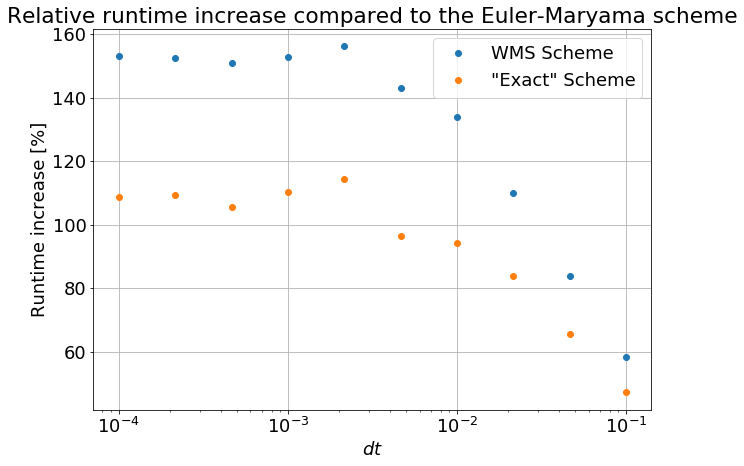

In [18]:
dts = np.logspace(np.log10(0.1),np.log10(0.0001),10)

plt.figure(figsize=(10,7))
plt.plot(dts,t_WMS,"o", label = "WMS Scheme")
plt.plot(dts,t_Exact,"o", label = "\"Exact\" Scheme")

plt.title("Relative runtime increase compared to the Euler-Maryama scheme")
plt.legend()
plt.xlabel("$dt$")
plt.ylabel("Runtime increase [%]")
plt.xscale("log")
plt.grid()

---
---

## 2.) Evaluating the accuracy of the simulations using two sample Kolmogorov-Smirnov test

In [0]:
#Number of generated trajectories
mc_rep = 10000

### As a function of $\gamma$

In [20]:
model = 'CIR_'
name = 'Ktest_Exact'

print(f"\n\nStaring Experiment {model}{name}.\n")

#Parameters:
Parameters = namedtuple('Parameters','X0 dt T kappa theta sigma')
P = Parameters(X0 = 0.5, dt = 0.01, T = 1,kappa = 1, theta = 1, sigma = 0.6)

#Variables:
var_name = 'gamma'
var = np.linspace(0.1,2,10)

sigma = list(map(lambda p: np.sqrt((2*P.kappa*P.theta)/p),var))

#Transforming the parameters into a more digestable form. This way the computation heavy part of the code needs less for cycles.
T = []
for i in range(len(var)):
  T.append([P.X0,P.dt,P.T,P.kappa,P.theta,sigma[i]])

start_time = time.time()
#GENERATING ALL TRAJECTORIES
X = np.zeros((len(T),mc_rep))
for i in range(len(T)):
  print(f"Making trajectories for X0 = {T[i][0]},dt = {T[i][1]},T = {T[i][2]},kappa = {T[i][3]},theta = {T[i][4]},sigma = {T[i][5]}.\n")

  s_time = time.time()
  n = 0
  for x in CIR_Prcss_mp(T[i][0],T[i][1],T[i][2],T[i][3],T[i][4],T[i][5], Exact = "True"):
    X[i,n] = x
    n += 1
  e_time = time.time()

  print(f"  Finished generating trajectories in {int((e_time-s_time)/60)} minutes and {e_time-s_time-int((e_time-s_time)/60)*60} seconds.[{i+1}/{len(T)}]\n")

#Memory Management
del T

end_time = time.time()

print(f"The experiment finished in {int((end_time-start_time)/60)} minutes and {end_time-start_time-int((end_time-start_time)/60)*60} seconds.\n")

Y = X



Staring Experiment CIR_Ktest_Exact.

Making trajectories for X0 = 0.5,dt = 0.01,T = 1,kappa = 1,theta = 1,sigma = 4.47213595499958.

  Finished generating trajectories in 0 minutes and 0.5549821853637695 seconds.[1/10]

Making trajectories for X0 = 0.5,dt = 0.01,T = 1,kappa = 1,theta = 1,sigma = 2.53546276418555.

  Finished generating trajectories in 0 minutes and 0.5497262477874756 seconds.[2/10]

Making trajectories for X0 = 0.5,dt = 0.01,T = 1,kappa = 1,theta = 1,sigma = 1.9569842191603266.

  Finished generating trajectories in 0 minutes and 0.5384588241577148 seconds.[3/10]

Making trajectories for X0 = 0.5,dt = 0.01,T = 1,kappa = 1,theta = 1,sigma = 1.651445647689541.

  Finished generating trajectories in 0 minutes and 0.5497801303863525 seconds.[4/10]

Making trajectories for X0 = 0.5,dt = 0.01,T = 1,kappa = 1,theta = 1,sigma = 1.4552137502179978.

  Finished generating trajectories in 0 minutes and 0.5283641815185547 seconds.[5/10]

Making trajectories for X0 = 0.5,dt = 0.0

In [21]:
model = 'CIR_'
name = 'Ktest_Euler'

print(f"\n\nStaring Experiment {model}{name}.\n")

#Parameters:
Parameters = namedtuple('Parameters','X0 dt T kappa theta sigma')
P = Parameters(X0 = 0.5, dt = 0.01, T = 1,kappa = 1, theta = 1, sigma = 0.6)

#Variables:
var_name = 'gamma'
var = np.linspace(0.1,2,10)

sigma = list(map(lambda p: np.sqrt((2*P.kappa*P.theta)/p),var))

#Transforming the parameters into a more digestable form. This way the computation heavy part of the code needs less for cycles.
T = []
for i in range(len(var)):
  T.append([P.X0,P.dt,P.T,P.kappa,P.theta,sigma[i]])

start_time = time.time()
#GENERATING ALL TRAJECTORIES
X = np.zeros((len(T),mc_rep))
for i in range(len(T)):
  print(f"Making trajectories for X0 = {T[i][0]},dt = {T[i][1]},T = {T[i][2]},kappa = {T[i][3]},theta = {T[i][4]},sigma = {T[i][5]}.\n")

  s_time = time.time()
  n = 0
  for x in CIR_Prcss_mp(T[i][0],T[i][1],T[i][2],T[i][3],T[i][4],T[i][5]):
    X[i,n] = x
    n += 1
  e_time = time.time()

  print(f"  Finished generating trajectories in {int((e_time-s_time)/60)} minutes and {e_time-s_time-int((e_time-s_time)/60)*60} seconds.[{i+1}/{len(T)}]\n")

#Memory Management
del T

end_time = time.time()

print(f"The experiment finished in {int((end_time-start_time)/60)} minutes and {end_time-start_time-int((end_time-start_time)/60)*60} seconds.\n")



Staring Experiment CIR_Ktest_Euler.

Making trajectories for X0 = 0.5,dt = 0.01,T = 1,kappa = 1,theta = 1,sigma = 4.47213595499958.

  Finished generating trajectories in 0 minutes and 0.2992827892303467 seconds.[1/10]

Making trajectories for X0 = 0.5,dt = 0.01,T = 1,kappa = 1,theta = 1,sigma = 2.53546276418555.

  Finished generating trajectories in 0 minutes and 0.30030012130737305 seconds.[2/10]

Making trajectories for X0 = 0.5,dt = 0.01,T = 1,kappa = 1,theta = 1,sigma = 1.9569842191603266.

  Finished generating trajectories in 0 minutes and 0.30281805992126465 seconds.[3/10]

Making trajectories for X0 = 0.5,dt = 0.01,T = 1,kappa = 1,theta = 1,sigma = 1.651445647689541.

  Finished generating trajectories in 0 minutes and 0.3126523494720459 seconds.[4/10]

Making trajectories for X0 = 0.5,dt = 0.01,T = 1,kappa = 1,theta = 1,sigma = 1.4552137502179978.

  Finished generating trajectories in 0 minutes and 0.29565000534057617 seconds.[5/10]

Making trajectories for X0 = 0.5,dt = 

In [0]:
pval_Euler = []
for i in range(len(Y)):
  pval_Euler.append(list(ks_2samp(X[i],Y[i]))[1])

In [23]:
model = 'CIR_'
name = 'Ktest_WMS'

print(f"\n\nStaring Experiment {model}{name}.\n")

#Parameters:
Parameters = namedtuple('Parameters','X0 dt T kappa theta sigma')
P = Parameters(X0 = 0.5, dt = 0.01, T = 1,kappa = 1, theta = 1, sigma = 0.6)

#Variables:
var_name = 'gamma'
var = np.linspace(0.1,2,10)

sigma = list(map(lambda p: np.sqrt((2*P.kappa*P.theta)/p),var))

#Transforming the parameters into a more digestable form. This way the computation heavy part of the code needs less for cycles.
T = []
for i in range(len(var)):
  T.append([P.X0,P.dt,P.T,P.kappa,P.theta,sigma[i]])

start_time = time.time()
#GENERATING ALL TRAJECTORIES
X = np.zeros((len(T),mc_rep))
for i in range(len(T)):
  print(f"Making trajectories for X0 = {T[i][0]},dt = {T[i][1]},T = {T[i][2]},kappa = {T[i][3]},theta = {T[i][4]},sigma = {T[i][5]}.\n")

  s_time = time.time()
  n = 0
  for x in CIR_Prcss_mp(T[i][0],T[i][1],T[i][2],T[i][3],T[i][4],T[i][5], WMS = "True"):
    X[i,n] = x
    n += 1
  e_time = time.time()

  t_WMS.append(e_time-s_time)
  print(f"  Finished generating trajectories in {int((e_time-s_time)/60)} minutes and {e_time-s_time-int((e_time-s_time)/60)*60} seconds.[{i+1}/{len(T)}]\n")

#Memory Management
del T

end_time = time.time()

print(f"The experiment finished in {int((end_time-start_time)/60)} minutes and {end_time-start_time-int((end_time-start_time)/60)*60} seconds.\n")



Staring Experiment CIR_Ktest_WMS.

Making trajectories for X0 = 0.5,dt = 0.01,T = 1,kappa = 1,theta = 1,sigma = 4.47213595499958.

  Finished generating trajectories in 0 minutes and 0.6682155132293701 seconds.[1/10]

Making trajectories for X0 = 0.5,dt = 0.01,T = 1,kappa = 1,theta = 1,sigma = 2.53546276418555.

  Finished generating trajectories in 0 minutes and 0.6771407127380371 seconds.[2/10]

Making trajectories for X0 = 0.5,dt = 0.01,T = 1,kappa = 1,theta = 1,sigma = 1.9569842191603266.

  Finished generating trajectories in 0 minutes and 0.6832399368286133 seconds.[3/10]

Making trajectories for X0 = 0.5,dt = 0.01,T = 1,kappa = 1,theta = 1,sigma = 1.651445647689541.

  Finished generating trajectories in 0 minutes and 0.6744964122772217 seconds.[4/10]

Making trajectories for X0 = 0.5,dt = 0.01,T = 1,kappa = 1,theta = 1,sigma = 1.4552137502179978.

  Finished generating trajectories in 0 minutes and 0.6675550937652588 seconds.[5/10]

Making trajectories for X0 = 0.5,dt = 0.01,

In [0]:
pval_WMS = []
for i in range(len(Y)):
  pval_WMS.append(list(ks_2samp(X[i],Y[i]))[1])

del X
del Y

#### Results

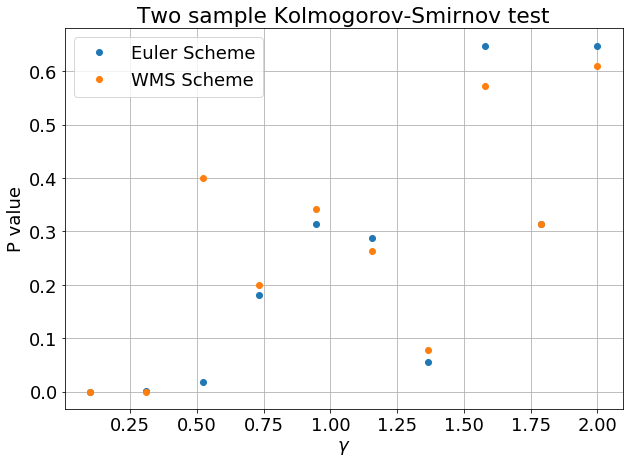

In [25]:
gammas = np.linspace(0.1,2,10)

plt.figure(figsize=(10,7))
plt.plot(gammas,pval_Euler,"o", label = "Euler Scheme")
plt.plot(gammas,pval_WMS,"o", label = "WMS Scheme")

plt.title("Two sample Kolmogorov-Smirnov test")
plt.legend()
plt.xlabel("$\gamma$")
plt.ylabel("P value")
plt.grid()

---

### As a function of $dt$

In [26]:
model = 'CIR_'
name = 'Ktest_Exact'

print(f"\n\nStaring Experiment {model}{name}.\n")

#Parameters:
Parameters = namedtuple('Parameters','X0 dt T kappa theta sigma')
P = Parameters(X0 = 0.5, dt = 0.01, T = 1,kappa = 1, theta = 1, sigma = 1)

#Variables:
var_name = 'dt'
var = np.logspace(np.log10(0.1),np.log10(0.0001),10)


#Transforming the parameters into a more digestable form. This way the computation heavy part of the code needs less for cycles.
T = []
for i in range(len(var)):
  T.append([P.X0,var[i],P.T,P.kappa,P.theta,P.sigma])

start_time = time.time()
#GENERATING ALL TRAJECTORIES
X = np.zeros((len(T),mc_rep))
for i in range(len(T)):
  print(f"Making trajectories for X0 = {T[i][0]},dt = {T[i][1]},T = {T[i][2]},kappa = {T[i][3]},theta = {T[i][4]},sigma = {T[i][5]}.\n")

  s_time = time.time()
  n = 0
  for x in CIR_Prcss_mp(T[i][0],T[i][1],T[i][2],T[i][3],T[i][4],T[i][5], Exact = "True"):
    X[i,n] = x
    n += 1
  e_time = time.time()

  print(f"  Finished generating trajectories in {int((e_time-s_time)/60)} minutes and {e_time-s_time-int((e_time-s_time)/60)*60} seconds.[{i+1}/{len(T)}]\n")

#Memory Management
del T

end_time = time.time()

print(f"The experiment finished in {int((end_time-start_time)/60)} minutes and {end_time-start_time-int((end_time-start_time)/60)*60} seconds.\n")

Y = X



Staring Experiment CIR_Ktest_Exact.

Making trajectories for X0 = 0.5,dt = 0.1,T = 1,kappa = 1,theta = 1,sigma = 1.

  Finished generating trajectories in 0 minutes and 0.09594321250915527 seconds.[1/10]

Making trajectories for X0 = 0.5,dt = 0.046415888336127795,T = 1,kappa = 1,theta = 1,sigma = 1.

  Finished generating trajectories in 0 minutes and 0.17074012756347656 seconds.[2/10]

Making trajectories for X0 = 0.5,dt = 0.021544346900318846,T = 1,kappa = 1,theta = 1,sigma = 1.

  Finished generating trajectories in 0 minutes and 0.3320441246032715 seconds.[3/10]

Making trajectories for X0 = 0.5,dt = 0.01,T = 1,kappa = 1,theta = 1,sigma = 1.

  Finished generating trajectories in 0 minutes and 0.6647341251373291 seconds.[4/10]

Making trajectories for X0 = 0.5,dt = 0.004641588833612782,T = 1,kappa = 1,theta = 1,sigma = 1.

  Finished generating trajectories in 0 minutes and 1.3409268856048584 seconds.[5/10]

Making trajectories for X0 = 0.5,dt = 0.0021544346900318843,T = 1,kappa 

In [27]:
model = 'CIR_'
name = 'Ktest_Euler'

print(f"\n\nStaring Experiment {model}{name}.\n")

#Parameters:
Parameters = namedtuple('Parameters','X0 dt T kappa theta sigma')
P = Parameters(X0 = 0.5, dt = 0.01, T = 1,kappa = 1, theta = 1, sigma = 1)

#Variables:
var_name = 'dt'
var = np.logspace(np.log10(0.1),np.log10(0.0001),10)

#Transforming the parameters into a more digestable form. This way the computation heavy part of the code needs less for cycles.
T = []
for i in range(len(var)):
  T.append([P.X0,var[i],P.T,P.kappa,P.theta,P.sigma])

start_time = time.time()
#GENERATING ALL TRAJECTORIES
X = np.zeros((len(T),mc_rep))
for i in range(len(T)):
  print(f"Making trajectories for X0 = {T[i][0]},dt = {T[i][1]},T = {T[i][2]},kappa = {T[i][3]},theta = {T[i][4]},sigma = {T[i][5]}.\n")

  s_time = time.time()
  n = 0
  for x in CIR_Prcss_mp(T[i][0],T[i][1],T[i][2],T[i][3],T[i][4],T[i][5]):
    X[i,n] = x
    n += 1
  e_time = time.time()

  print(f"  Finished generating trajectories in {int((e_time-s_time)/60)} minutes and {e_time-s_time-int((e_time-s_time)/60)*60} seconds.[{i+1}/{len(T)}]\n")

#Memory Management
del T

end_time = time.time()

print(f"The experiment finished in {int((end_time-start_time)/60)} minutes and {end_time-start_time-int((end_time-start_time)/60)*60} seconds.\n")



Staring Experiment CIR_Ktest_Euler.

Making trajectories for X0 = 0.5,dt = 0.1,T = 1,kappa = 1,theta = 1,sigma = 1.

  Finished generating trajectories in 0 minutes and 0.07376766204833984 seconds.[1/10]

Making trajectories for X0 = 0.5,dt = 0.046415888336127795,T = 1,kappa = 1,theta = 1,sigma = 1.

  Finished generating trajectories in 0 minutes and 0.10689282417297363 seconds.[2/10]

Making trajectories for X0 = 0.5,dt = 0.021544346900318846,T = 1,kappa = 1,theta = 1,sigma = 1.

  Finished generating trajectories in 0 minutes and 0.18173718452453613 seconds.[3/10]

Making trajectories for X0 = 0.5,dt = 0.01,T = 1,kappa = 1,theta = 1,sigma = 1.

  Finished generating trajectories in 0 minutes and 0.3415706157684326 seconds.[4/10]

Making trajectories for X0 = 0.5,dt = 0.004641588833612782,T = 1,kappa = 1,theta = 1,sigma = 1.

  Finished generating trajectories in 0 minutes and 0.6697087287902832 seconds.[5/10]

Making trajectories for X0 = 0.5,dt = 0.0021544346900318843,T = 1,kappa

In [0]:
pval_Euler = []
for i in range(len(Y)):
  pval_Euler.append(list(ks_2samp(X[i],Y[i]))[1])

In [29]:
model = 'CIR_'
name = 'Ktest_WMS'

print(f"\n\nStaring Experiment {model}{name}.\n")

#Parameters:
Parameters = namedtuple('Parameters','X0 dt T kappa theta sigma')
P = Parameters(X0 = 0.5, dt = 0.01, T = 1,kappa = 1, theta = 1, sigma = 1)

#Variables:
var_name = 'dt'
var = np.logspace(np.log10(0.1),np.log10(0.0001),10)

#Transforming the parameters into a more digestable form. This way the computation heavy part of the code needs less for cycles.
T = []
for i in range(len(var)):
  T.append([P.X0,var[i],P.T,P.kappa,P.theta,P.sigma])

start_time = time.time()
#GENERATING ALL TRAJECTORIES
X = np.zeros((len(T),mc_rep))
for i in range(len(T)):
  print(f"Making trajectories for X0 = {T[i][0]},dt = {T[i][1]},T = {T[i][2]},kappa = {T[i][3]},theta = {T[i][4]},sigma = {T[i][5]}.\n")

  s_time = time.time()
  n = 0
  for x in CIR_Prcss_mp(T[i][0],T[i][1],T[i][2],T[i][3],T[i][4],T[i][5], WMS = "True"):
    X[i,n] = x
    n += 1
  e_time = time.time()

  t_WMS.append(e_time-s_time)
  print(f"  Finished generating trajectories in {int((e_time-s_time)/60)} minutes and {e_time-s_time-int((e_time-s_time)/60)*60} seconds.[{i+1}/{len(T)}]\n")

#Memory Management
del T

end_time = time.time()

print(f"The experiment finished in {int((end_time-start_time)/60)} minutes and {end_time-start_time-int((end_time-start_time)/60)*60} seconds.\n")



Staring Experiment CIR_Ktest_WMS.

Making trajectories for X0 = 0.5,dt = 0.1,T = 1,kappa = 1,theta = 1,sigma = 1.

  Finished generating trajectories in 0 minutes and 0.11594176292419434 seconds.[1/10]

Making trajectories for X0 = 0.5,dt = 0.046415888336127795,T = 1,kappa = 1,theta = 1,sigma = 1.

  Finished generating trajectories in 0 minutes and 0.19570088386535645 seconds.[2/10]

Making trajectories for X0 = 0.5,dt = 0.021544346900318846,T = 1,kappa = 1,theta = 1,sigma = 1.

  Finished generating trajectories in 0 minutes and 0.39220571517944336 seconds.[3/10]

Making trajectories for X0 = 0.5,dt = 0.01,T = 1,kappa = 1,theta = 1,sigma = 1.

  Finished generating trajectories in 0 minutes and 0.7873039245605469 seconds.[4/10]

Making trajectories for X0 = 0.5,dt = 0.004641588833612782,T = 1,kappa = 1,theta = 1,sigma = 1.

  Finished generating trajectories in 0 minutes and 1.6195063591003418 seconds.[5/10]

Making trajectories for X0 = 0.5,dt = 0.0021544346900318843,T = 1,kappa =

In [0]:
pval_WMS = []
for i in range(len(Y)):
  pval_WMS.append(list(ks_2samp(X[i],Y[i]))[1])

del X
del Y

#### Results

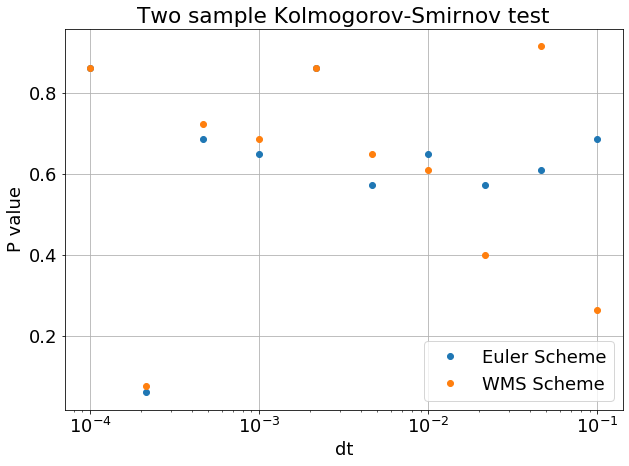

In [31]:
gammas = np.logspace(np.log10(0.1),np.log10(0.0001),10)

plt.figure(figsize=(10,7))
plt.plot(gammas,pval_Euler,"o", label = "Euler Scheme")
plt.plot(gammas,pval_WMS,"o", label = "WMS Scheme")

plt.title("Two sample Kolmogorov-Smirnov test")
plt.legend()
plt.xlabel("dt")
plt.ylabel("P value")
plt.xscale("log")
plt.grid()

---
---

## 3.) Measuring the time to cross the barriers
Lower barrier: $0$

Upper barrier $2 X_0$

In [0]:
#Number of generated trajectories
mc_rep = 10000

In [33]:
model = 'CIR_'
name = 'full_Exact'

print(f"\n\nStaring Experiment {model}{name}.\n")

#Parameters:
Parameters = namedtuple('Parameters','X0 dt T kappa theta sigma')
P = Parameters(X0 = 0.5, dt = 0.0001, T = 2,kappa = 1, theta = 1, sigma = 0.6)

#Variables:
var_name = 'gamma'
var = [0.1,3]

sigma = list(map(lambda p: np.sqrt((2*P.kappa*P.theta)/p),var))

#Transforming the parameters into a more digestable form. This way the computation heavy part of the code needs less for cycles.
T = []
for i in range(len(var)):
  T.append([P.X0,P.dt,P.T,P.kappa,P.theta,sigma[i]])

start_time = time.time()
#GENERATING ALL TRAJECTORIES
X = []
for i in range(len(T)):
  print(f"Making trajectories for X0 = {T[i][0]},dt = {T[i][1]},T = {T[i][2]},kappa = {T[i][3]},theta = {T[i][4]},sigma = {T[i][5]}.\n")

  s_time = time.time()
  X.append(CIR_Prcss_mp(T[i][0],T[i][1],T[i][2],T[i][3],T[i][4],T[i][5], Exact = "True", Path = "True"))
  e_time = time.time()

  print(f"  Finished generating trajectories in {int((e_time-s_time)/60)} minutes and {e_time-s_time-int((e_time-s_time)/60)*60} seconds.[{i+1}/{len(T)}]\n")

#Memory Management
del T

end_time = time.time()

print(f"The experiment finished in {int((end_time-start_time)/60)} minutes and {end_time-start_time-int((end_time-start_time)/60)*60} seconds.\n")



Staring Experiment CIR_full_Exact.

Making trajectories for X0 = 0.5,dt = 0.0001,T = 2,kappa = 1,theta = 1,sigma = 4.47213595499958.

  Finished generating trajectories in 1 minutes and 39.77515244483948 seconds.[1/2]

Making trajectories for X0 = 0.5,dt = 0.0001,T = 2,kappa = 1,theta = 1,sigma = 0.816496580927726.

  Finished generating trajectories in 1 minutes and 36.21955132484436 seconds.[2/2]

The experiment finished in 3 minutes and 15.997932195663452 seconds.



In [0]:
#X[0] ---> under gammac
#X[1] ---> above gammac

In [0]:
tau0s_u = []
tau2X0s_u = []

for i in range(len(X[0])):
  tau0 = 1
  tau2X0 = 1
  t = 0
  for j in range(len(X[0][i])):
    if (X[0][i][j] < 0.0001) & (t <= tau0):
      tau0 = t
    elif (X[0][i][j] >= 1) & (t <= tau2X0):
      tau2X0 = t
    t += 0.0001
  if tau0 > tau2X0:
    tau2X0s_u.append(tau2X0)
  else:
    tau0s_u.append(tau0)

In [0]:
tau0s_a = []
tau2X0s_a = []

for i in range(len(X[1])):
  tau0 = 1
  tau2X0 = 1
  t = 0
  for j in range(len(X[1][i])):
    if (X[1][i][j] < 0.0001) & (t <= tau0):
      tau0 = t
    elif (X[1][i][j] >= 1) & (t <= tau2X0):
      tau2X0 = t
    t += 0.0001
  if tau0 > tau2X0:
    tau2X0s_a.append(tau2X0)
  else:
    tau0s_a.append(tau0)

### Results

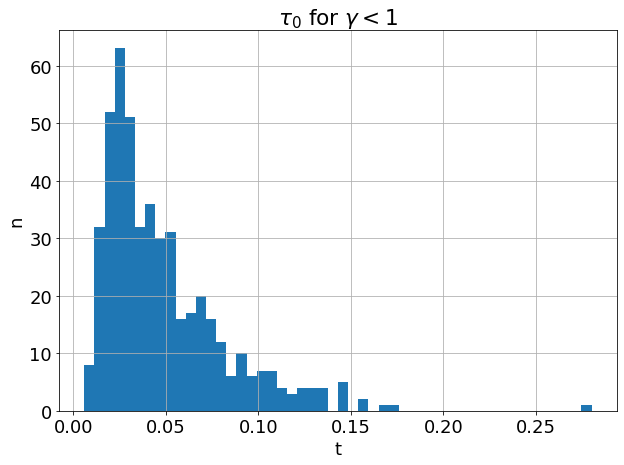

In [37]:
plt.figure(figsize=(10,7))
hist, bins, patches = plt.hist(tau0s_u,bins = 50)

plt.title("$\\tau_0$ for $\gamma < 1$")
plt.xlabel("t")
plt.ylabel("n")
plt.grid()

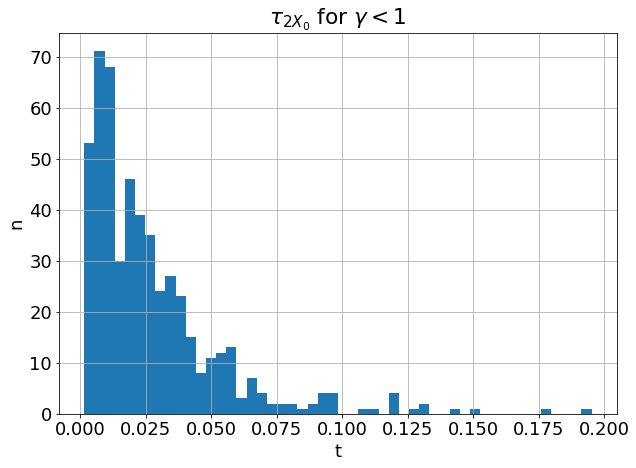

In [38]:
plt.figure(figsize=(10,7))
hist, bins, patches = plt.hist(tau2X0s_u, bins = 50)

plt.title("$\\tau_{2X_0}$ for $\gamma < 1$")
plt.xlabel("t")
plt.ylabel("n")
plt.grid()

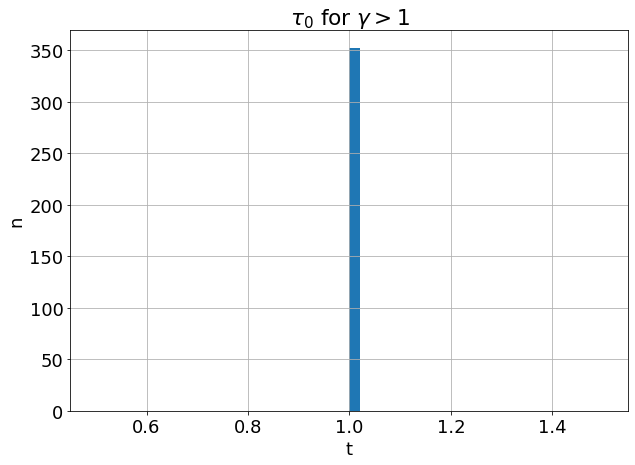

In [39]:
plt.figure(figsize=(10,7))
hist, bins, patches = plt.hist(tau0s_a, bins = 50)

plt.title("$\\tau_0$ for $\gamma > 1$")
plt.xlabel("t")
plt.ylabel("n")
plt.grid()

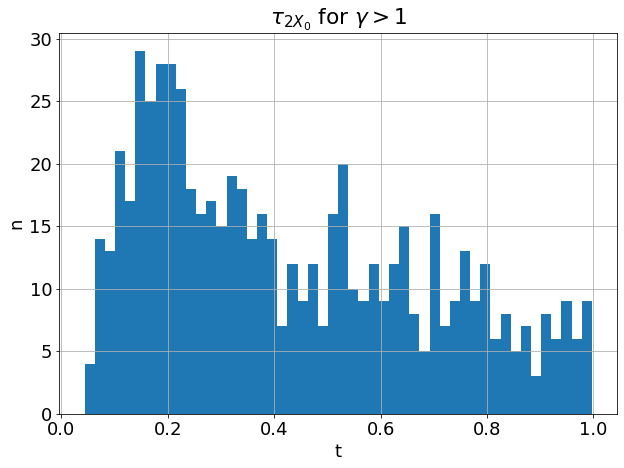

In [40]:
plt.figure(figsize=(10,7))
hist, bins, patches = plt.hist(tau2X0s_a, bins = 50)

plt.title("$\\tau_{2X_0}$ for $\gamma > 1$")
plt.xlabel("t")
plt.ylabel("n")
plt.grid()

---
---

## 4.) Findig $\gamma_c$ numerically

In [0]:
#Number of generated trajectories
mc_rep = 10000

In [42]:
model = 'CIR_'
name = 'Barrier_Exact'

print(f"\n\nStaring Experiment {model}{name}.\n")

#Parameters:
Parameters = namedtuple('Parameters','X0 dt T kappa theta sigma')
P = Parameters(X0 = 0.5, dt = 0.0001, T = 1,kappa = 1, theta = 1, sigma = 1)

#Variables:
var_name = 'gamma'
var = np.linspace(0.1,2,20)

sigma = list(map(lambda p: np.sqrt((2*P.kappa*P.theta)/p),var))

var2_name = "dt"
var2 = np.logspace(np.log10(0.1),np.log10(0.0001),20)

#Transforming the parameters into a more digestable form. This way the computation heavy part of the code needs less for cycles.
T = []
for i in range(len(var)):
  for j in range(len(var2)):
    T.append([P.X0,var2[j],P.T,P.kappa,P.theta,sigma[i]])

start_time = time.time()
#GENERATING ALL TRAJECTORIES
X = []
for i in range(len(T)):
  print(f"Making trajectories for X0 = {T[i][0]},dt = {T[i][1]},T = {T[i][2]},kappa = {T[i][3]},theta = {T[i][4]},sigma = {T[i][5]}.\n")

  s_time = time.time()
  X.append(sort(CIR_Prcss_mp(T[i][0],T[i][1],T[i][2],T[i][3],T[i][4],T[i][5], Exact = "True", Barrier = "True")))
  e_time = time.time()

  print(f"  Finished generating trajectories in {int((e_time-s_time)/60)} minutes and {e_time-s_time-int((e_time-s_time)/60)*60} seconds.[{i+1}/{len(T)}]\n")

#Memory Management
del T

end_time = time.time()

print(f"The experiment finished in {int((end_time-start_time)/60)} minutes and {end_time-start_time-int((end_time-start_time)/60)*60} seconds.\n")



Staring Experiment CIR_Barrier_Exact.

Making trajectories for X0 = 0.5,dt = 0.1,T = 1,kappa = 1,theta = 1,sigma = 4.47213595499958.

  Finished generating trajectories in 0 minutes and 0.21668434143066406 seconds.[1/400]

Making trajectories for X0 = 0.5,dt = 0.06951927961775606,T = 1,kappa = 1,theta = 1,sigma = 4.47213595499958.

  Finished generating trajectories in 0 minutes and 0.22855854034423828 seconds.[2/400]

Making trajectories for X0 = 0.5,dt = 0.04832930238571752,T = 1,kappa = 1,theta = 1,sigma = 4.47213595499958.

  Finished generating trajectories in 0 minutes and 0.24860024452209473 seconds.[3/400]

Making trajectories for X0 = 0.5,dt = 0.033598182862837826,T = 1,kappa = 1,theta = 1,sigma = 4.47213595499958.

  Finished generating trajectories in 0 minutes and 0.27779412269592285 seconds.[4/400]

Making trajectories for X0 = 0.5,dt = 0.023357214690901226,T = 1,kappa = 1,theta = 1,sigma = 4.47213595499958.

  Finished generating trajectories in 0 minutes and 0.31644439

In [0]:
P = np.zeros((len(var),len(var2)))

for i in range(len(var)):
  for j in range(len(var2)):
    P[i,j] = X[i*len(var2) + j][0]

P_lim = []
for i in range(len(var)):
  P_lim.append(Richardson(P[i,:],np.log10(var2),5))

---

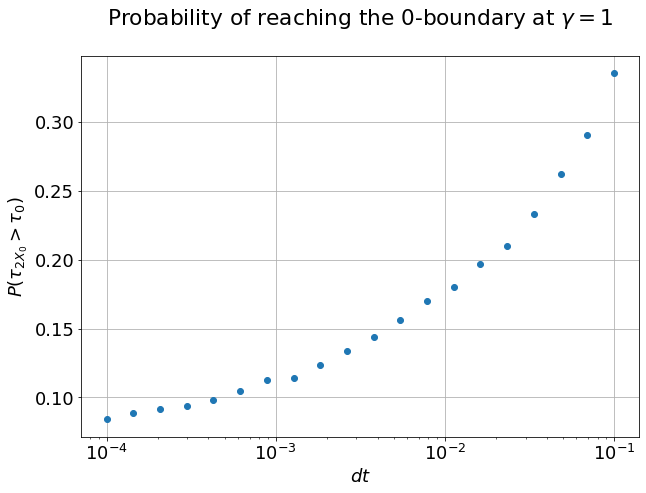

In [44]:
plt.figure(figsize=(10,7))
plt.plot(var2,P[9,:],"o")

plt.title("Probability of reaching the 0-boundary at $\gamma = 1$\n")

plt.xlabel("$dt$")
plt.ylabel("$P(\\tau_{2X_0}>\\tau_{0})$")
plt.grid()
plt.xscale("log")

### Results

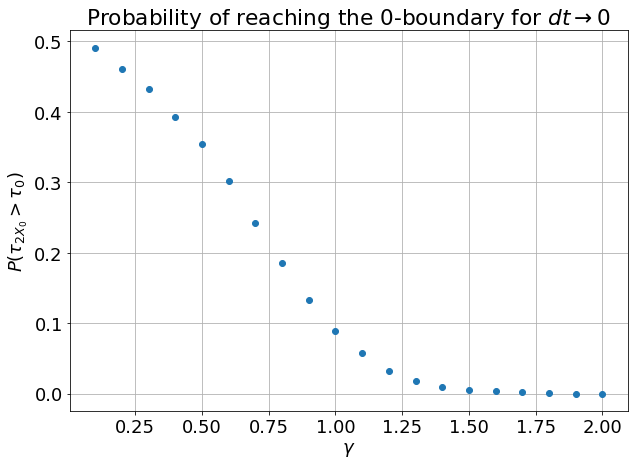

In [45]:
plt.figure(figsize=(10,7))
plt.plot(var,P_lim,"o")

plt.title("Probability of reaching the 0-boundary for $dt \\rightarrow 0$ ")

plt.xlabel("$\gamma$")
plt.ylabel("$P(\\tau_{2X_0}>\\tau_{0})$")
plt.grid()

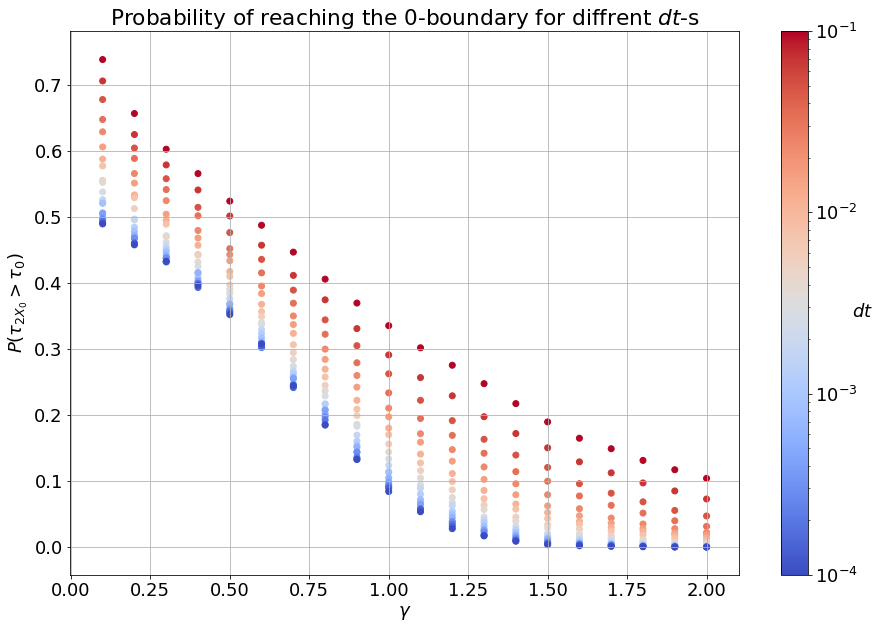

In [46]:
dt = np.zeros((20,20))
for i in range(0,20):
  for j in range(0,20):
    dt[i,j] = var2[i]

plt.figure(figsize=(15,10))
for i in range(20):
  plt.scatter(var,P[:,i],c = dt[i], norm=colors.LogNorm(vmin=dt.min(),vmax=dt.max()), cmap = "coolwarm")

cbar = plt.colorbar()
cbar.set_label("$dt$", rotation = 0)

plt.title("Probability of reaching the 0-boundary for diffrent $dt$-s")
plt.xlabel("$\gamma$")
plt.ylabel("$P(\\tau_{2X_0}>\\tau_{0})$")
plt.grid()

---
---

## 5.) Simulating the special case of $\gamma = \frac{1}{2}$ as a squared Ornstein-Uhlenbeck process

In [0]:
#Number of generated trajectories
mc_rep = 10000

In [48]:
model = 'CIR_'
name = 'SOUP_sticky'

print(f"\n\nStaring Experiment {model}{name}.\n")

#Parameters:
Parameters = namedtuple('Parameters','X0 dt T kappa theta sigma')
P = Parameters(X0 = 0.5, dt = 0.0001, T = 1,kappa = 1, theta = 1, sigma = 1)

#Variables:
var_name = 'gamma'
var = [0.5]

sigma = list(map(lambda p: np.sqrt((2*P.kappa*P.theta)/p),var))


#Transforming the parameters into a more digestable form. This way the computation heavy part of the code needs less for cycles.
T = []
for i in range(len(var)):
  T.append([P.X0,P.dt,P.T,P.kappa,P.theta,sigma[i]])

start_time = time.time()
#GENERATING ALL TRAJECTORIES
X_SOUP_sticky = []
for i in range(len(T)):
  print(f"Making trajectories for X0 = {T[i][0]},dt = {T[i][1]},T = {T[i][2]},kappa = {T[i][3]},theta = {T[i][4]},sigma = {T[i][5]}.\n")

  s_time = time.time()
  X_SOUP_sticky.append(CIR_Prcss_mp(T[i][0],T[i][1],T[i][2],T[i][3],T[i][4],T[i][5], SOUP = "True"))
  e_time = time.time()

  print(f"  Finished generating trajectories in {int((e_time-s_time)/60)} minutes and {e_time-s_time-int((e_time-s_time)/60)*60} seconds.[{i+1}/{len(T)}]\n")

#Memory Management
del T

end_time = time.time()

print(f"The experiment finished in {int((end_time-start_time)/60)} minutes and {end_time-start_time-int((end_time-start_time)/60)*60} seconds.\n")



Staring Experiment CIR_SOUP_sticky.

Making trajectories for X0 = 0.5,dt = 0.0001,T = 1,kappa = 1,theta = 1,sigma = 2.0.

  Finished generating trajectories in 4 minutes and 49.86739993095398 seconds.[1/1]

The experiment finished in 4 minutes and 49.86890935897827 seconds.



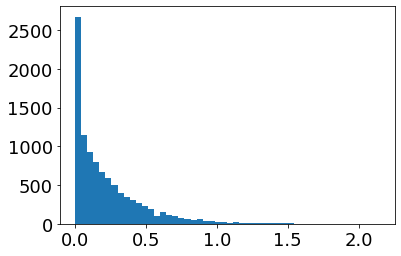

In [49]:
n,bins,patches = plt.hist(X_SOUP_sticky[0], bins = 50)

In [50]:
model = 'CIR_'
name = 'SOUP_reflective'

print(f"\n\nStaring Experiment {model}{name}.\n")

#Parameters:
Parameters = namedtuple('Parameters','X0 dt T kappa theta sigma')
P = Parameters(X0 = 0.5, dt = 0.0001, T = 1,kappa = 1, theta = 1, sigma = 1)

#Variables:
var_name = 'gamma'
var = [0.5]

sigma = list(map(lambda p: np.sqrt((2*P.kappa*P.theta)/p),var))


#Transforming the parameters into a more digestable form. This way the computation heavy part of the code needs less for cycles.
T = []
for i in range(len(var)):
  T.append([P.X0,P.dt,P.T,P.kappa,P.theta,sigma[i]])

start_time = time.time()
#GENERATING ALL TRAJECTORIES
X_SOUP_reflective = []
for i in range(len(T)):
  print(f"Making trajectories for X0 = {T[i][0]},dt = {T[i][1]},T = {T[i][2]},kappa = {T[i][3]},theta = {T[i][4]},sigma = {T[i][5]}.\n")

  s_time = time.time()
  X_SOUP_reflective.append(CIR_Prcss_mp(T[i][0],T[i][1],T[i][2],T[i][3],T[i][4],T[i][5], SOUP = "True", Reflective_Boundary = True))
  e_time = time.time()

  print(f"  Finished generating trajectories in {int((e_time-s_time)/60)} minutes and {e_time-s_time-int((e_time-s_time)/60)*60} seconds.[{i+1}/{len(T)}]\n")

#Memory Management
del T

end_time = time.time()

print(f"The experiment finished in {int((end_time-start_time)/60)} minutes and {end_time-start_time-int((end_time-start_time)/60)*60} seconds.\n")



Staring Experiment CIR_SOUP_reflective.

Making trajectories for X0 = 0.5,dt = 0.0001,T = 1,kappa = 1,theta = 1,sigma = 2.0.

  Finished generating trajectories in 4 minutes and 50.123591899871826 seconds.[1/1]

The experiment finished in 4 minutes and 50.12543296813965 seconds.



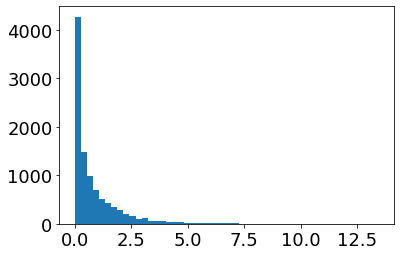

In [51]:
n,bins,patches = plt.hist(X_SOUP_reflective[0], bins = 50)

In [52]:
model = 'CIR_'
name = 'WMS_sticky'

print(f"\n\nStaring Experiment {model}{name}.\n")

#Parameters:
Parameters = namedtuple('Parameters','X0 dt T kappa theta sigma')
P = Parameters(X0 = 0.5, dt = 0.0001, T = 1,kappa = 1, theta = 1, sigma = 1)

#Variables:
var_name = 'gamma'
var = [0.5]

sigma = list(map(lambda p: np.sqrt((2*P.kappa*P.theta)/p),var))


#Transforming the parameters into a more digestable form. This way the computation heavy part of the code needs less for cycles.
T = []
for i in range(len(var)):
  T.append([P.X0,P.dt,P.T,P.kappa,P.theta,sigma[i]])

start_time = time.time()
#GENERATING ALL TRAJECTORIES
X_WMS_sticky = []
for i in range(len(T)):
  print(f"Making trajectories for X0 = {T[i][0]},dt = {T[i][1]},T = {T[i][2]},kappa = {T[i][3]},theta = {T[i][4]},sigma = {T[i][5]}.\n")

  s_time = time.time()
  X_WMS_sticky.append(CIR_Prcss_mp(T[i][0],T[i][1],T[i][2],T[i][3],T[i][4],T[i][5], WMS = "True", Sticky_Boundary = True))
  e_time = time.time()

  print(f"  Finished generating trajectories in {int((e_time-s_time)/60)} minutes and {e_time-s_time-int((e_time-s_time)/60)*60} seconds.[{i+1}/{len(T)}]\n")

#Memory Management
del T

end_time = time.time()

print(f"The experiment finished in {int((end_time-start_time)/60)} minutes and {end_time-start_time-int((end_time-start_time)/60)*60} seconds.\n")



Staring Experiment CIR_WMS_sticky.

Making trajectories for X0 = 0.5,dt = 0.0001,T = 1,kappa = 1,theta = 1,sigma = 2.0.

  Finished generating trajectories in 9 minutes and 7.682271242141724 seconds.[1/1]

The experiment finished in 9 minutes and 7.684279918670654 seconds.



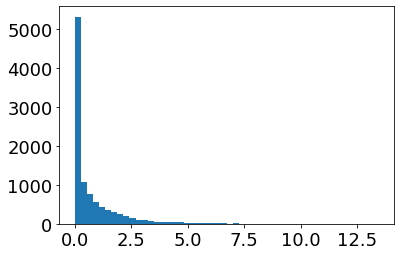

In [53]:
n,bins,patches = plt.hist(X_WMS_sticky[0], bins = 50)

In [54]:
model = 'CIR_'
name = 'WMS_reflective'

print(f"\n\nStaring Experiment {model}{name}.\n")

#Parameters:
Parameters = namedtuple('Parameters','X0 dt T kappa theta sigma')
P = Parameters(X0 = 0.5, dt = 0.0001, T = 1,kappa = 1, theta = 1, sigma = 1)

#Variables:
var_name = 'gamma'
var = [0.5]

sigma = list(map(lambda p: np.sqrt((2*P.kappa*P.theta)/p),var))


#Transforming the parameters into a more digestable form. This way the computation heavy part of the code needs less for cycles.
T = []
for i in range(len(var)):
  T.append([P.X0,P.dt,P.T,P.kappa,P.theta,sigma[i]])

start_time = time.time()
#GENERATING ALL TRAJECTORIES
X_WMS_reflective = []
for i in range(len(T)):
  print(f"Making trajectories for X0 = {T[i][0]},dt = {T[i][1]},T = {T[i][2]},kappa = {T[i][3]},theta = {T[i][4]},sigma = {T[i][5]}.\n")

  s_time = time.time()
  X_WMS_reflective.append(CIR_Prcss_mp(T[i][0],T[i][1],T[i][2],T[i][3],T[i][4],T[i][5], WMS = "True"))
  e_time = time.time()

  print(f"  Finished generating trajectories in {int((e_time-s_time)/60)} minutes and {e_time-s_time-int((e_time-s_time)/60)*60} seconds.[{i+1}/{len(T)}]\n")

#Memory Management
del T

end_time = time.time()

print(f"The experiment finished in {int((end_time-start_time)/60)} minutes and {end_time-start_time-int((end_time-start_time)/60)*60} seconds.\n")



Staring Experiment CIR_WMS_reflective.

Making trajectories for X0 = 0.5,dt = 0.0001,T = 1,kappa = 1,theta = 1,sigma = 2.0.

  Finished generating trajectories in 10 minutes and 7.9720704555511475 seconds.[1/1]

The experiment finished in 10 minutes and 7.974077939987183 seconds.



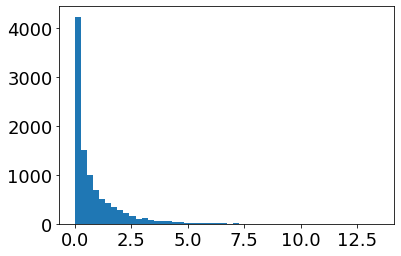

In [55]:
n,bins,patches = plt.hist(X_WMS_reflective[0], bins = 50)

In [56]:
model = 'CIR_'
name = 'Euler_sticky'

print(f"\n\nStaring Experiment {model}{name}.\n")

#Parameters:
Parameters = namedtuple('Parameters','X0 dt T kappa theta sigma')
P = Parameters(X0 = 0.5, dt = 0.0001, T = 1,kappa = 1, theta = 1, sigma = 1)

#Variables:
var_name = 'gamma'
var = [0.5]

sigma = list(map(lambda p: np.sqrt((2*P.kappa*P.theta)/p),var))


#Transforming the parameters into a more digestable form. This way the computation heavy part of the code needs less for cycles.
T = []
for i in range(len(var)):
  T.append([P.X0,P.dt,P.T,P.kappa,P.theta,sigma[i]])

start_time = time.time()
#GENERATING ALL TRAJECTORIES
X_Euler_sticky = []
for i in range(len(T)):
  print(f"Making trajectories for X0 = {T[i][0]},dt = {T[i][1]},T = {T[i][2]},kappa = {T[i][3]},theta = {T[i][4]},sigma = {T[i][5]}.\n")

  s_time = time.time()
  X_Euler_sticky.append(CIR_Prcss_mp(T[i][0],T[i][1],T[i][2],T[i][3],T[i][4],T[i][5], Sticky_Boundary = True))
  e_time = time.time()

  print(f"  Finished generating trajectories in {int((e_time-s_time)/60)} minutes and {e_time-s_time-int((e_time-s_time)/60)*60} seconds.[{i+1}/{len(T)}]\n")

#Memory Management
del T

end_time = time.time()

print(f"The experiment finished in {int((end_time-start_time)/60)} minutes and {end_time-start_time-int((end_time-start_time)/60)*60} seconds.\n")



Staring Experiment CIR_Euler_sticky.

Making trajectories for X0 = 0.5,dt = 0.0001,T = 1,kappa = 1,theta = 1,sigma = 2.0.

  Finished generating trajectories in 3 minutes and 13.754205465316772 seconds.[1/1]

The experiment finished in 3 minutes and 13.755568742752075 seconds.



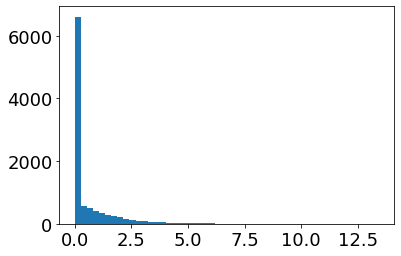

In [57]:
n,bins,patches = plt.hist(X_Euler_sticky[0], bins = 50)

In [58]:
model = 'CIR_'
name = 'Euler_reflective'

print(f"\n\nStaring Experiment {model}{name}.\n")

#Parameters:
Parameters = namedtuple('Parameters','X0 dt T kappa theta sigma')
P = Parameters(X0 = 0.5, dt = 0.0001, T = 1,kappa = 1, theta = 1, sigma = 1)

#Variables:
var_name = 'gamma'
var = [0.5]

sigma = list(map(lambda p: np.sqrt((2*P.kappa*P.theta)/p),var))


#Transforming the parameters into a more digestable form. This way the computation heavy part of the code needs less for cycles.
T = []
for i in range(len(var)):
  T.append([P.X0,P.dt,P.T,P.kappa,P.theta,sigma[i]])

start_time = time.time()
#GENERATING ALL TRAJECTORIES
X_Euler_reflective = []
for i in range(len(T)):
  print(f"Making trajectories for X0 = {T[i][0]},dt = {T[i][1]},T = {T[i][2]},kappa = {T[i][3]},theta = {T[i][4]},sigma = {T[i][5]}.\n")

  s_time = time.time()
  X_Euler_reflective.append(CIR_Prcss_mp(T[i][0],T[i][1],T[i][2],T[i][3],T[i][4],T[i][5]))
  e_time = time.time()

  print(f"  Finished generating trajectories in {int((e_time-s_time)/60)} minutes and {e_time-s_time-int((e_time-s_time)/60)*60} seconds.[{i+1}/{len(T)}]\n")

#Memory Management
del T

end_time = time.time()

print(f"The experiment finished in {int((end_time-start_time)/60)} minutes and {end_time-start_time-int((end_time-start_time)/60)*60} seconds.\n")



Staring Experiment CIR_Euler_reflective.

Making trajectories for X0 = 0.5,dt = 0.0001,T = 1,kappa = 1,theta = 1,sigma = 2.0.

  Finished generating trajectories in 4 minutes and 22.357341289520264 seconds.[1/1]

The experiment finished in 4 minutes and 22.359976053237915 seconds.



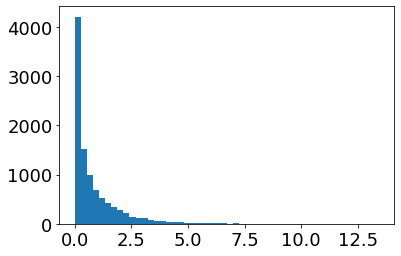

In [59]:
n,bins,patches = plt.hist(X_Euler_reflective[0], bins = 50)

In [60]:
model = 'CIR_'
name = 'Exact'

print(f"\n\nStaring Experiment {model}{name}.\n")

#Parameters:
Parameters = namedtuple('Parameters','X0 dt T kappa theta sigma')
P = Parameters(X0 = 0.5, dt = 0.0001, T = 1,kappa = 1, theta = 1, sigma = 1)

#Variables:
var_name = 'gamma'
var = [0.5]

sigma = list(map(lambda p: np.sqrt((2*P.kappa*P.theta)/p),var))


#Transforming the parameters into a more digestable form. This way the computation heavy part of the code needs less for cycles.
T = []
for i in range(len(var)):
  T.append([P.X0,P.dt,P.T,P.kappa,P.theta,sigma[i]])

start_time = time.time()
#GENERATING ALL TRAJECTORIES
X_Exact = []
for i in range(len(T)):
  print(f"Making trajectories for X0 = {T[i][0]},dt = {T[i][1]},T = {T[i][2]},kappa = {T[i][3]},theta = {T[i][4]},sigma = {T[i][5]}.\n")

  s_time = time.time()
  X_Exact.append(CIR_Prcss_mp(T[i][0],T[i][1],T[i][2],T[i][3],T[i][4],T[i][5], Exact = True))
  e_time = time.time()

  print(f"  Finished generating trajectories in {int((e_time-s_time)/60)} minutes and {e_time-s_time-int((e_time-s_time)/60)*60} seconds.[{i+1}/{len(T)}]\n")

#Memory Management
del T

end_time = time.time()

print(f"The experiment finished in {int((end_time-start_time)/60)} minutes and {end_time-start_time-int((end_time-start_time)/60)*60} seconds.\n")



Staring Experiment CIR_Exact.

Making trajectories for X0 = 0.5,dt = 0.0001,T = 1,kappa = 1,theta = 1,sigma = 2.0.

  Finished generating trajectories in 7 minutes and 58.98332715034485 seconds.[1/1]

The experiment finished in 7 minutes and 58.98522114753723 seconds.



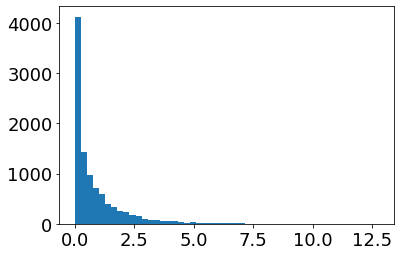

In [61]:
n,bins,patches = plt.hist(X_Exact[0], bins = 50)

---

In [0]:
K_test_sticky = np.zeros((3,3))
K_test_sticky[0,0] = list(ks_2samp(X_Euler_sticky[0],X_Euler_sticky[0]))[1]
K_test_sticky[0,1] = list(ks_2samp(X_Euler_sticky[0],X_WMS_sticky[0]))[1]
K_test_sticky[0,2] = list(ks_2samp(X_Euler_sticky[0],X_SOUP_sticky[0]))[1]
K_test_sticky[1,0] = list(ks_2samp(X_WMS_sticky[0],X_Euler_sticky[0]))[1]
K_test_sticky[1,1] = list(ks_2samp(X_WMS_sticky[0],X_WMS_sticky[0]))[1]
K_test_sticky[1,2] = list(ks_2samp(X_WMS_sticky[0],X_SOUP_sticky[0]))[1]
K_test_sticky[2,0] = list(ks_2samp(X_SOUP_sticky[0],X_Euler_sticky[0]))[1]
K_test_sticky[2,1] = list(ks_2samp(X_SOUP_sticky[0],X_WMS_sticky[0]))[1]
K_test_sticky[2,2] = list(ks_2samp(X_SOUP_sticky[0],X_SOUP_sticky[0]))[1]

In [0]:
K_test_reflective = np.zeros((4,4))
K_test_reflective[0,0] = list(ks_2samp(X_Exact[0],X_Exact[0]))[1]
K_test_reflective[0,1] = list(ks_2samp(X_Exact[0],X_Euler_reflective[0]))[1]
K_test_reflective[0,2] = list(ks_2samp(X_Exact[0],X_WMS_reflective[0]))[1]
K_test_reflective[0,3] = list(ks_2samp(X_Exact[0],X_SOUP_reflective[0]))[1]
K_test_reflective[1,0] = list(ks_2samp(X_Euler_reflective[0],X_Exact[0]))[1]
K_test_reflective[1,1] = list(ks_2samp(X_Euler_reflective[0],X_Euler_reflective[0]))[1]
K_test_reflective[1,2] = list(ks_2samp(X_Euler_reflective[0],X_WMS_reflective[0]))[1]
K_test_reflective[1,3] = list(ks_2samp(X_Euler_reflective[0],X_SOUP_reflective[0]))[1]
K_test_reflective[2,0] = list(ks_2samp(X_WMS_reflective[0],X_Exact[0]))[1]
K_test_reflective[2,1] = list(ks_2samp(X_WMS_reflective[0],X_Euler_reflective[0]))[1]
K_test_reflective[2,2] = list(ks_2samp(X_WMS_reflective[0],X_WMS_reflective[0]))[1]
K_test_reflective[2,3] = list(ks_2samp(X_WMS_reflective[0],X_SOUP_reflective[0]))[1]
K_test_reflective[3,0] = list(ks_2samp(X_SOUP_reflective[0],X_Exact[0]))[1]
K_test_reflective[3,1] = list(ks_2samp(X_SOUP_reflective[0],X_Euler_reflective[0]))[1]
K_test_reflective[3,2] = list(ks_2samp(X_SOUP_reflective[0],X_WMS_reflective[0]))[1]
K_test_reflective[3,3] = list(ks_2samp(X_SOUP_reflective[0],X_SOUP_reflective[0]))[1]

### Results

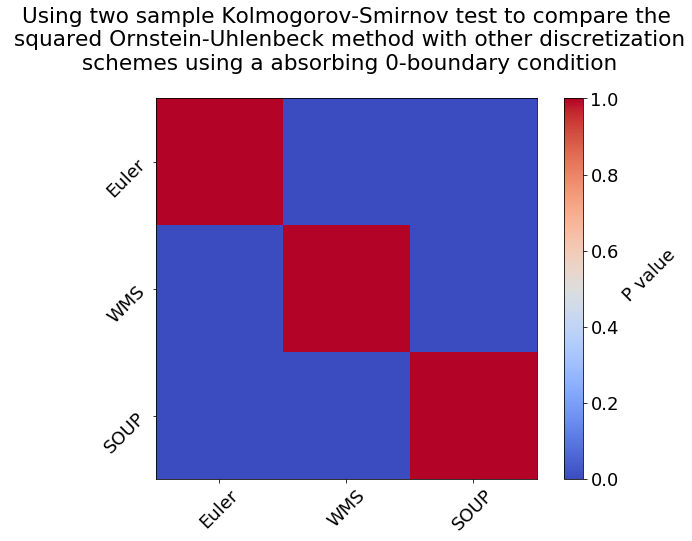

In [64]:
plt.figure(figsize=(10,7))
plt.imshow(K_test_sticky,cmap='coolwarm')
cbar = plt.colorbar()
cbar.set_label("          P value", rotation = 45)

plt.xticks([0,1,2], ["Euler","WMS","SOUP"], rotation=45)
plt.yticks([0,1,2], ["Euler","WMS","SOUP"], rotation=45)

title = plt.title("Using two sample Kolmogorov-Smirnov test to compare the\n squared Ornstein-Uhlenbeck method with other discretization\n schemes using a absorbing 0-boundary condition\n")

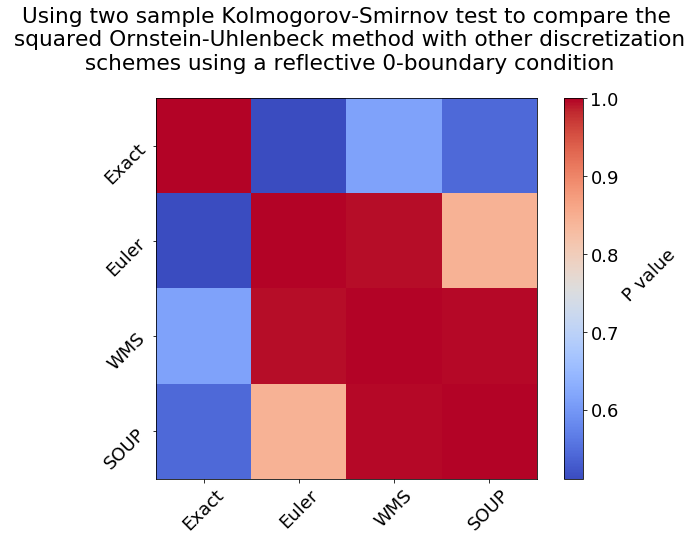

In [65]:
plt.figure(figsize=(10,7))
plt.imshow(K_test_reflective,cmap='coolwarm')

cbar = plt.colorbar()
cbar.set_label("          P value", rotation = 45)

plt.xticks([0,1,2,3], ["Exact","Euler","WMS","SOUP"], rotation=45)
plt.yticks([0,1,2,3], ["Exact","Euler","WMS","SOUP"], rotation=45)

title = plt.title("Using two sample Kolmogorov-Smirnov test to compare the\n squared Ornstein-Uhlenbeck method with other discretization\n schemes using a reflective 0-boundary condition\n")

---
---

## Appendix

### A.) Relationship between the CIR-Process and the Noncentral $\chi ^2$-distribution

A noncentral $\chi^2$-distribution can be described with the probability density function:
$$f_\chi (x,k,\lambda) = \sum_{x = 0}^{\infty}{\frac{e^{-\lambda/2}(\lambda/2)^i}{i!}f_{Y_k+2i}(x)}$$
Where $Y_q$ is $\chi^2$ distributed with degrees of freedom of $q$.
The parameters of this thistribution:
* $k$ degrees of freedom
* $\lambda$ noncentrality parameter

According to [2] the CIR process can be simulated by setting the degrees of freedom and non-centrality parameters as follows:
* $k := \frac{4\kappa\theta}{\sigma^2} = 2\gamma$
* $\lambda := X_{t_n}\eta(dt)$
Where we introduced the function $\eta(dt)$ as 
$$ \eta(dt) := \frac{4\kappa}{\sigma^2} e^{-\kappa dt} (1-e^{-\kappa dt})$$

With this the $t_{n+1}$-th step looks like:
$$ X_{t_{n+1}} = \chi^2_k (\lambda) \frac{e^{-\kappa dt}}{\eta(dt)} $$

We can use **numpy.random.noncentral_chisquare** to draw random numbers from the noncentral $\chi^2$-distribution.


References:

[1] https://en.wikipedia.org/wiki/Noncentral_chi-squared_distribution

[2] https://arxiv.org/pdf/0802.4411.pdf

---

### B.) CIR as a squared Ornstein-Uhlenbeck process

Starting from
$$ dX_t = \kappa (\theta -X_t)dt + \sigma \sqrt{X_t}dW_t $$
We can introduce
$$ Y_t(X_t) := \sqrt{X_t} $$
Ito's lemma states that if $X_t$ follows the SDE
$$ dX_t = \mu_t dt + \sigma_t dW_t$$
Then the function $Y_t(X_t)$ has to obey the following SDE:
$$ dY_t = \left( \frac{\partial Y_t}{\partial t} + \mu_t \frac{\partial Y_t}{\partial x} + \frac{\sigma_t^2}{2}\frac{\partial Y_t^2}{\partial^2 x} \right) dt +  \sigma_t \frac{\partial Y_t}{\partial x} dW_t $$

In the case of the CIR-process with $Y_t$ introduced earlier this SDE will be
$$
dY_t = \left[\left(\frac{\kappa\theta}{2}-\frac{\sigma^2}{8}\right)\frac{1}{Y_t} - \frac{\kappa}{2}Y_t\right]dt + \frac{\sigma}{2}dW_t
$$
In the special case of $\frac{\kappa\theta}{2}-\frac{\sigma^2}{8} = 0$, which in terms of $\gamma$  means $\gamma = 0.5$ will result in
$$
dY_t =  - \frac{\kappa}{2}Y_tdt + \frac{\sigma}{2}dW_t
$$
Which is an Ornstein-Uhlenbeck-type SDE.

This has a known solution:
$$
Y_t = Y_0e^{-\frac{\kappa}{2}t} + \frac{\sigma}{2}\int_{0}^{t}{e^{-\frac{\kappa}{2}(t-t')}dW_{t'}}
$$
Furthermore the PDF is also known:
$$
f(Y,t) = \sqrt{\frac{\kappa}{8\pi\sigma^2(1-e^{-\kappa(t-t_0)})}} exp\left[-\frac{\kappa}{8\sigma^2} \frac{(Y-Y_0e^{-\frac{\kappa}{2}(t-t_0)})^2}{1-e^{-{\kappa}(t-t_0)}}\right]
$$
We can transform this back using
$$
f_X(x) = f_Y(g^{-1}(x))\left|\frac{d}{dx} g^{-1}(x)\right|
$$
With $X = Y^2 \rightarrow g^{-1}(x) = \sqrt{x} \rightarrow \frac{d}{dx} g^{-1}(x)= \frac{1}{2} \frac{1}{\sqrt{x}}$

Substituting it into the transformation rule the PDF for $X_t$ given $X_0$ and $t_0$ will be
$$
f(X,t) = \sqrt{\frac{\kappa}{32\pi\sigma^2(1-e^{-\kappa(t-t_0)})}} \frac{1}{\sqrt{X}}exp\left[-\frac{\kappa}{8\sigma^2} \frac{\left(\sqrt{X}-\sqrt{X_0}e^{-\frac{\kappa}{2}(t-t_0)}\right)^2}{1-e^{-{\kappa}(t-t_0)}}\right]
$$